# Use Gurobi Optimizer

In [1]:
import gurobipy as gp

try:
    m = gp.Model("test")
    print("Gurobi license is working!")
except gp.GurobiError as e:
    print(f"Error: {e}")


Restricted license - for non-production use only - expires 2026-11-23
Gurobi license is working!


# Centralized Optimization Model

The centralized model assumes global access to network information and uses Integer Linear Programming (ILP) to allocate resources optimally. 

## Objective Function

The objective function maximizes overall QoE:

$$
\text{Maximize: } \sum_{i} w_{i} \cdot \sum_{j} q_{j} \cdot x_{ij}
$$

where:
- w_i is the weight of user i
- q_j is the quality score of resolution j
- x_ij ∈ {0,1} indicates whether user i is assigned resolution j

## Constraints

1. Each user is assigned at most one resolution:
   $$
   \sum_{j} x_{ij} \leq 1, \quad \forall i
   $$

2. Resolutions cannot exceed user bandwidth capability:
   $$
   x_{ij} = 0, \quad \forall j \text{ such that } B(j) > \text{max\_bitrate}(i)
   $$

3. Bandwidth usage on each link must not exceed capacity:
   $$
   b_{lk} = \sum_{j} m_{lk,j} \cdot B(j), \quad b_{lk} \leq C_{lk}, \quad \forall (l, k)
   $$

4. If user i is assigned resolution j, all links along its path must transmit that resolution:
   $$
   m_{lk,j} \geq x_{ij}, \quad \forall i, \forall j, \forall (l, k) \in \text{Path}(i)
   $$

## Complexity Analysis

The centralized model must solve a global ILP problem. The complexity grows with the number of variables (V) and constraints (C):

$$
O(2^V \cdot \text{poly}(C))
$$

where V and C are determined as follows:

Variables:
$$
\text{Variables: } n \cdot k + L + L \cdot k
$$

Constraints:
$$
\text{Constraints: } n + n \cdot k + 2L + n \cdot k \cdot P
$$

where:
- n is the number of users
- k is the number of resolutions
- L is the number of links
- P is the average path length

This exponential complexity makes the centralized model impractical for large-scale systems.

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) Platinum 8358P CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 64 physical cores, 64 logical processors, using up to 32 threads

Optimize a model with 227 rows, 140 columns and 505 nonzeros
Model fingerprint: 0xff9c2e42
Variable types: 20 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+02]
Found heuristic solution: objective 0.0000000
Presolve removed 227 rows and 140 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 64 available processors)

Solution count 2: -29 0 
No other solutions better than -29

Optimal solution found (tolerance 1.00e-04)
Best objective -2.900000000000e+01, best bound -2.900000


Optimal solution found!

Client assignments:
  Client Resolution  Bandwidth
0      A         1K          8
1      B         4K         45
2      C         8K        200
3      D         8K        200
4      E         2K         16
5      F         4K         45
6      G         4K         45
7      H         4K         45
8      I         4K         45
9      J         4K         45

Link bandwidth usage:
                From                To  Usage (Mbps)  Capacity (Mbps)  \
0             Server  Core_Forwarder_1         269.0              500   
1             Server  Core_Forwarder_2         269.0              500   
2   Core_Forwarder_1  Edge_Forwarder_A         269.0              300   
3   Core_Forwarder_1  Edge_Forwarder_B         269.0              300   
4   Core_Forwarder_2  Edge_Forwarder_A          69.0              200   
5   Core_Forwarder_2  Edge_Forwarder_B         269.0              300   
6   Core_Forwarder_2  Edge_Forwarder_C         269.0              400   
7   Ed

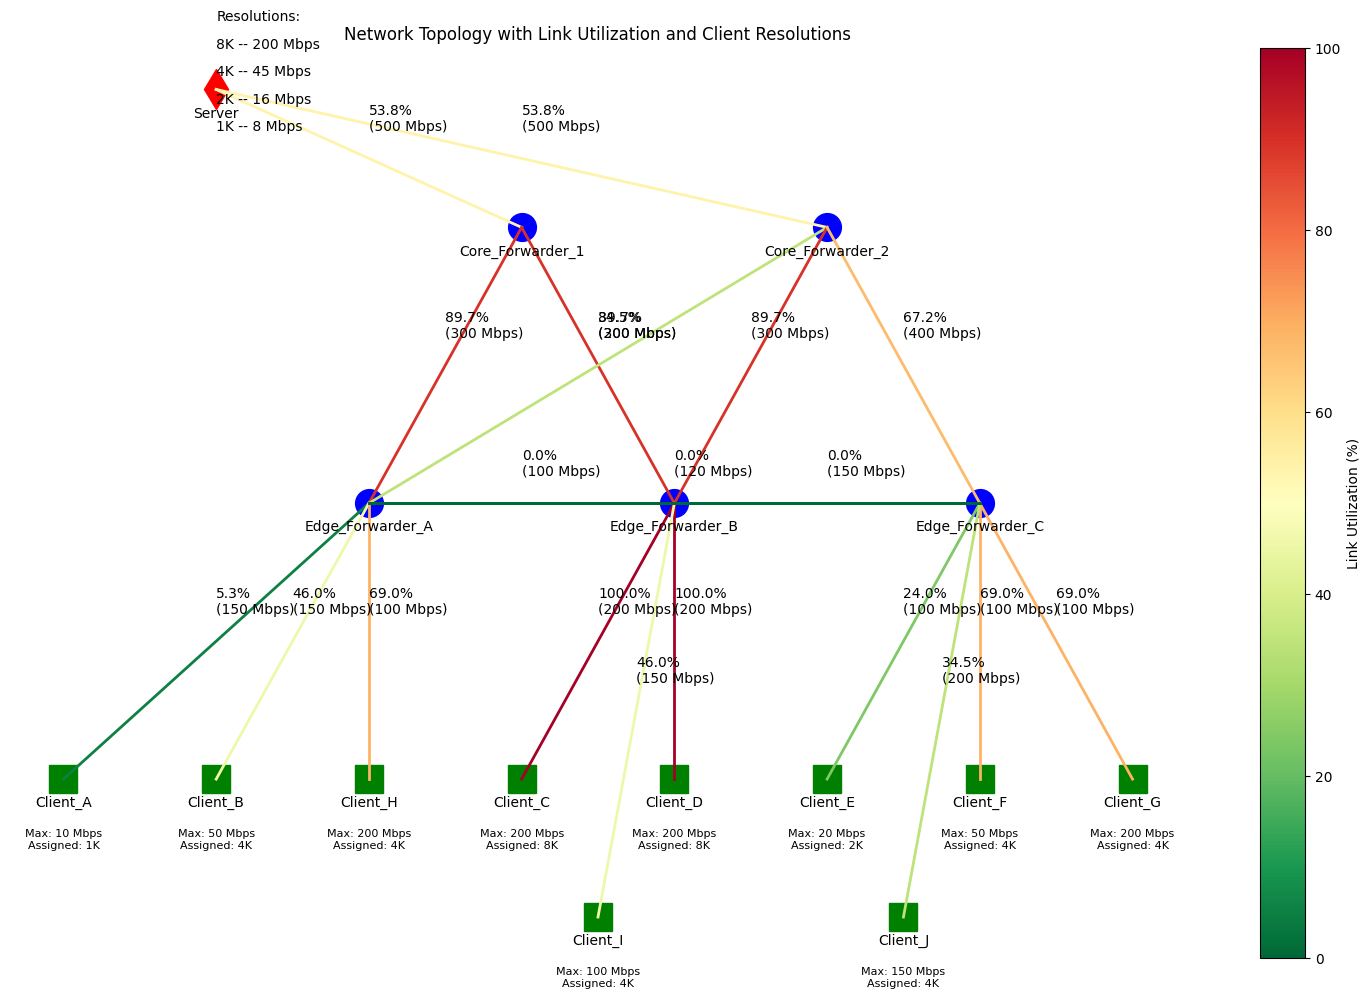

In [3]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt

def define_problem_data():
    # Resolution bandwidth requirements (Mbps)
    B = {
        '8K': 200,
        '4K': 45,
        '2K': 16,
        '1K': 8
    }
    
    # Quality scores for each resolution
    q = {
        '8K': 4,
        '4K': 3,
        '2K': 2,
        '1K': 1
    }
    
    # Client maximum bitrates
    max_bitrate = {
        'A': 10,
        'B': 50,
        'C': 200,
        'D': 200,
        'E': 20,
        'F': 50,
        'G': 200,
        'H': 200,
        'I': 100,
        'J': 150
    }
    
    # Link remaining estimated bandwidths (Mbps)
    links = {
        ('Server', 'Core_Forwarder_1'): 500,
        ('Server', 'Core_Forwarder_2'): 500,
        ('Core_Forwarder_1', 'Edge_Forwarder_A'): 300,
        ('Core_Forwarder_1', 'Edge_Forwarder_B'): 300,
        ('Core_Forwarder_2', 'Edge_Forwarder_A'): 200,
        ('Core_Forwarder_2', 'Edge_Forwarder_B'): 300,
        ('Core_Forwarder_2', 'Edge_Forwarder_C'): 400,
        ('Edge_Forwarder_A', 'Client_A'): 150,
        ('Edge_Forwarder_A', 'Client_B'): 150,
        ('Edge_Forwarder_B', 'Client_C'): 200,
        ('Edge_Forwarder_B', 'Client_D'): 200,
        ('Edge_Forwarder_C', 'Client_E'): 100,
        ('Edge_Forwarder_C', 'Client_F'): 100,
        ('Edge_Forwarder_C', 'Client_G'): 100,
        ('Edge_Forwarder_A', 'Client_H'): 100,
        ('Edge_Forwarder_B', 'Client_I'): 150,
        ('Edge_Forwarder_C', 'Client_J'): 200,
        # Parallel links
        ('Edge_Forwarder_A', 'Edge_Forwarder_B'): 100,
        ('Edge_Forwarder_B', 'Edge_Forwarder_C'): 150,
        ('Edge_Forwarder_A', 'Edge_Forwarder_C'): 120
    }
    
    # Define paths for each client (multiple paths are allowed)
    paths = {
        'A': [
            [('Server', 'Core_Forwarder_1'), ('Core_Forwarder_1', 'Edge_Forwarder_A'), ('Edge_Forwarder_A', 'Client_A')],
            [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_A'), ('Edge_Forwarder_A', 'Client_A')]
        ],
        'B': [
            [('Server', 'Core_Forwarder_1'), ('Core_Forwarder_1', 'Edge_Forwarder_A'), ('Edge_Forwarder_A', 'Client_B')],
            [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_A'), ('Edge_Forwarder_A', 'Client_B')]
        ],
        'C': [
            [('Server', 'Core_Forwarder_1'), ('Core_Forwarder_1', 'Edge_Forwarder_B'), ('Edge_Forwarder_B', 'Client_C')],
            [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_B'), ('Edge_Forwarder_B', 'Client_C')]
        ],
        'D': [
            [('Server', 'Core_Forwarder_1'), ('Core_Forwarder_1', 'Edge_Forwarder_B'), ('Edge_Forwarder_B', 'Client_D')],
            [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_B'), ('Edge_Forwarder_B', 'Client_D')]
        ],
        'E': [
            [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_C'), ('Edge_Forwarder_C', 'Client_E')],
        ],
        'F': [
            [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_C'), ('Edge_Forwarder_C', 'Client_F')]
        ],
        'G': [
            [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_C'), ('Edge_Forwarder_C', 'Client_G')]
        ],
        'H': [
            [('Server', 'Core_Forwarder_1'), ('Core_Forwarder_1', 'Edge_Forwarder_A'), ('Edge_Forwarder_A', 'Client_H')]
        ],
        'I': [
            [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_B'), ('Edge_Forwarder_B', 'Client_I')]
        ],
        'J': [
            [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_C'), ('Edge_Forwarder_C', 'Client_J')]
        ]
    }
    
    # Client importance weights (default to 1 for all clients)
    weights = {
        'A': 1,
        'B': 1,
        'C': 1,
        'D': 1,
        'E': 1,
        'F': 1,
        'G': 1,
        'H': 1,
        'I': 1,
        'J': 1
    }
    
    return B, q, max_bitrate, links, paths, weights

class VideoOptimizationModel:
    def __init__(self):
        self.B, self.q, self.max_bitrate, self.links, self.paths, self.weights = define_problem_data()
        self.clients = list(self.max_bitrate.keys())
        self.resolutions = list(self.B.keys())
        self.model = None
        self.x = None
        self.m = None
        self.b = None
        # Create the model right after initialization
        self.create_model()
        
    def create_model(self):
        """Create the optimization model and variables"""
        self.model = gp.Model("video_quality_optimization")
        
        # Create variables
        self.x = self.model.addVars(self.clients, self.resolutions, vtype=GRB.BINARY, name="x")
        self.m = self.model.addVars(self.links.keys(), self.resolutions, vtype=GRB.BINARY, name="m")
        self.b = self.model.addVars(self.links.keys(), vtype=GRB.CONTINUOUS, name="b")
        
    def set_objective(self):
        """Set the optimization objective"""
        obj = -gp.quicksum(
            self.weights[i] * self.q[j] * self.x[i, j]
            for i in self.clients for j in self.resolutions
        )
        self.model.setObjective(obj, GRB.MINIMIZE)
        
    def add_constraints(self):
        """Add all model constraints"""
        # User assignment constraint
        for i in self.clients:
            self.model.addConstr(
                gp.quicksum(self.x[i, j] for j in self.resolutions) <= 1,
                name=f"user_assignment_{i}"
            )
        
        # User capability constraint
        for i in self.clients:
            for j in self.resolutions:
                if self.B[j] > self.max_bitrate[i]:
                    self.model.addConstr(self.x[i, j] == 0, name=f"user_capability_{i}_{j}")
        
        # Link bandwidth usage
        for l, k in self.links:
            self.model.addConstr(
                self.b[l, k] == gp.quicksum(self.m[l, k, j] * self.B[j] for j in self.resolutions),
                name=f"link_bandwidth_usage_{l}_{k}"
            )
        
        # Link capacity constraint
        for l, k in self.links:
            self.model.addConstr(
                self.b[l, k] <= self.links[l, k],
                name=f"link_capacity_{l}_{k}"
            )
        
        # Multicast logic constraint
        for i in self.clients:
            for j in self.resolutions:
                for path in self.paths[i]:
                    for l, k in path:
                        self.model.addConstr(
                            self.m[l, k, j] >= self.x[i, j],
                            name=f"multicast_logic_{i}_{j}_{l}_{k}"
                        )
    
    def optimize(self):
        """Run the optimization"""
        self.model.optimize()
    
    def print_results(self):
        """Print and visualize optimization results"""
        if self.model.status == GRB.OPTIMAL:
            print("\nOptimal solution found!")
            
            results = []
            for i in self.clients:
                for j in self.resolutions:
                    if self.x[i, j].x > 0.5:
                        results.append({
                            'Client': i,
                            'Resolution': j,
                            'Bandwidth': self.B[j]
                        })
            
            df_results = pd.DataFrame(results)
            print("\nClient assignments:")
            print(df_results)
            
            link_usage = []
            for (l, k) in self.links:
                link_usage.append({
                    'From': l,
                    'To': k,
                    'Usage (Mbps)': round(self.b[l, k].x, 2),
                    'Capacity (Mbps)': self.links[l, k],
                    'Utilization (%)': round(self.b[l, k].x / self.links[l, k] * 100, 2)
                })
            
            df_links = pd.DataFrame(link_usage)
            print("\nLink bandwidth usage:")
            print(df_links)
            
            self.plot_network_with_utilization(df_links)
    
    def plot_network_with_utilization(self, df_links):
        """Plot network topology with link utilization and client resolutions"""
        fig, ax = plt.subplots(figsize=(15, 10))
        
        pos = {
            'Server': (0.2, 0.8),
            'Core_Forwarder_1': (0.4, 0.7),
            'Core_Forwarder_2': (0.6, 0.7),
            'Edge_Forwarder_A': (0.3, 0.5),
            'Edge_Forwarder_B': (0.5, 0.5),
            'Edge_Forwarder_C': (0.7, 0.5),
            'Client_A': (0.1, 0.3),
            'Client_B': (0.2, 0.3),
            'Client_C': (0.4, 0.3),
            'Client_D': (0.5, 0.3),
            'Client_E': (0.6, 0.3),
            'Client_F': (0.7, 0.3),
            'Client_G': (0.8, 0.3),
            'Client_H': (0.3, 0.3),
            'Client_I': (0.45, 0.2),
            'Client_J': (0.65, 0.2),
        }
        
        client_resolutions = {}
        for i in self.clients:
            for j in self.resolutions:
                if self.x[i, j].x > 0.5:
                    client_resolutions[i] = j
        
        utilization_dict = {(row['From'], row['To']): row['Utilization (%)'] for _, row in df_links.iterrows()}
        
        def get_color(util_pct):
            return plt.cm.RdYlGn_r(util_pct / 100)
        
        for node, (x, y) in pos.items():
            if 'Client' in node:
                ax.plot(x, y, 'gs', markersize=20)
                ax.text(x, y - 0.02, node, ha='center')
                client_id = node.split('_')[1]
                resolution = client_resolutions.get(client_id, 'N/A')
                ax.text(x, y - 0.05, f'Max: {self.max_bitrate[client_id]} Mbps\nAssigned: {resolution}', ha='center', fontsize=8)
            elif 'Forwarder' in node:
                ax.plot(x, y, 'bo', markersize=20)
                ax.text(x, y - 0.02, node, ha='center')
            else:
                ax.plot(x, y, 'rd', markersize=20)
                ax.text(x, y - 0.02, node, ha='center')
        
        for (l, k), util_pct in utilization_dict.items():
            x1, y1 = pos[l]
            x2, y2 = pos[k]
            ax.plot([x1, x2], [y1, y2], '-', color=get_color(util_pct), linewidth=2)
            label = f'{round(util_pct, 1)}%\n({self.links[l, k]} Mbps)'
            ax.text((x1 + x2) / 2, (y1 + y2) / 2 + 0.02, label)
        
        norm = plt.Normalize(0, 100)
        sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Link Utilization (%)')
        
        ax.text(0.2, 0.85, 'Resolutions:', ha='left')
        ax.text(0.2, 0.83, '8K -- 200 Mbps', ha='left')
        ax.text(0.2, 0.81, '4K -- 45 Mbps', ha='left')
        ax.text(0.2, 0.79, '2K -- 16 Mbps', ha='left')
        ax.text(0.2, 0.77, '1K -- 8 Mbps', ha='left')
        
        ax.set_title('Network Topology with Link Utilization and Client Resolutions')
        ax.axis('off')
        plt.tight_layout()
        plt.show()

def run_optimization():
    model = VideoOptimizationModel()
    model.set_objective()
    model.add_constraints()
    model.optimize()
    model.print_results()

if __name__ == "__main__":
    run_optimization()


# Distributed Optimization Model and System Architecture

## Distributed Down-to-Top Optimization Model

The distributed model adopts a hierarchical approach where forwarders independently optimize their local configurations based on downstream clients. Results are aggregated and propagated upward, ensuring global consistency. This approach reduces computational complexity while maintaining near-optimal performance.

### Objective Function

$$
\text{Maximize: } \sum_{i \in I_r} w_i \cdot \sum_j q_j \cdot x_{ij}^r
$$

where:
- I_r is the set of users managed by forwarder r
- x_ij^r ∈ {0,1} indicates whether forwarder r assigns resolution j to user i

### Constraints

1. Each user can be assigned at most one resolution by the forwarder:
   $$
   \sum_j x_{ij}^r \leq 1, \quad \forall i \in I_r
   $$

2. Resolutions cannot exceed the user's bandwidth capability:
   $$
   x_{ij}^r = 0, \quad \forall j \text{ such that } B(j) > \text{max\_bitrate}(i)
   $$

3. Bandwidth usage on each link must not exceed capacity:
   $$
   b_{lk}^r = \sum_{i \in I_r} \sum_j x_{ij}^r B(j), \quad b_{lk}^r \leq C_{lk}, \quad \forall (l, k) \in N_r
   $$

4. Higher-layer forwarders must respect constraints aggregated from lower layers:
   $$
   x_{ij}^r \geq x_{ij}^{\text{lower}}, \quad \forall i \in I_r, \forall j
   $$

### Complexity Analysis

For a forwarder managing n_r users and L_r links:

$$
\text{Variables: } n_r \cdot k + L_r + L_r \cdot k
$$

$$
\text{Constraints: } n_r + n_r \cdot k + 2L_r
$$

Since n_r ≪ n and L_r ≪ L, the complexity per forwarder is orders of magnitude lower than in the centralized model. The total complexity is approximately:

$$
O\left(\sum_r 2^{V_r} \cdot \text{poly}(C_r)\right)
$$

where V_r and C_r are the variables and constraints for each forwarder r. This localized optimization enables near real-time computation even in large networks.



Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) Platinum 8358P CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 64 physical cores, 64 logical processors, using up to 32 threads

Optimize a model with 23 rows, 16 columns and 56 nonzeros
Model fingerprint: 0x3ef3ccad
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 23 rows and 16 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 64 available processors)

Solution count 2: 7 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective 7.000000000000

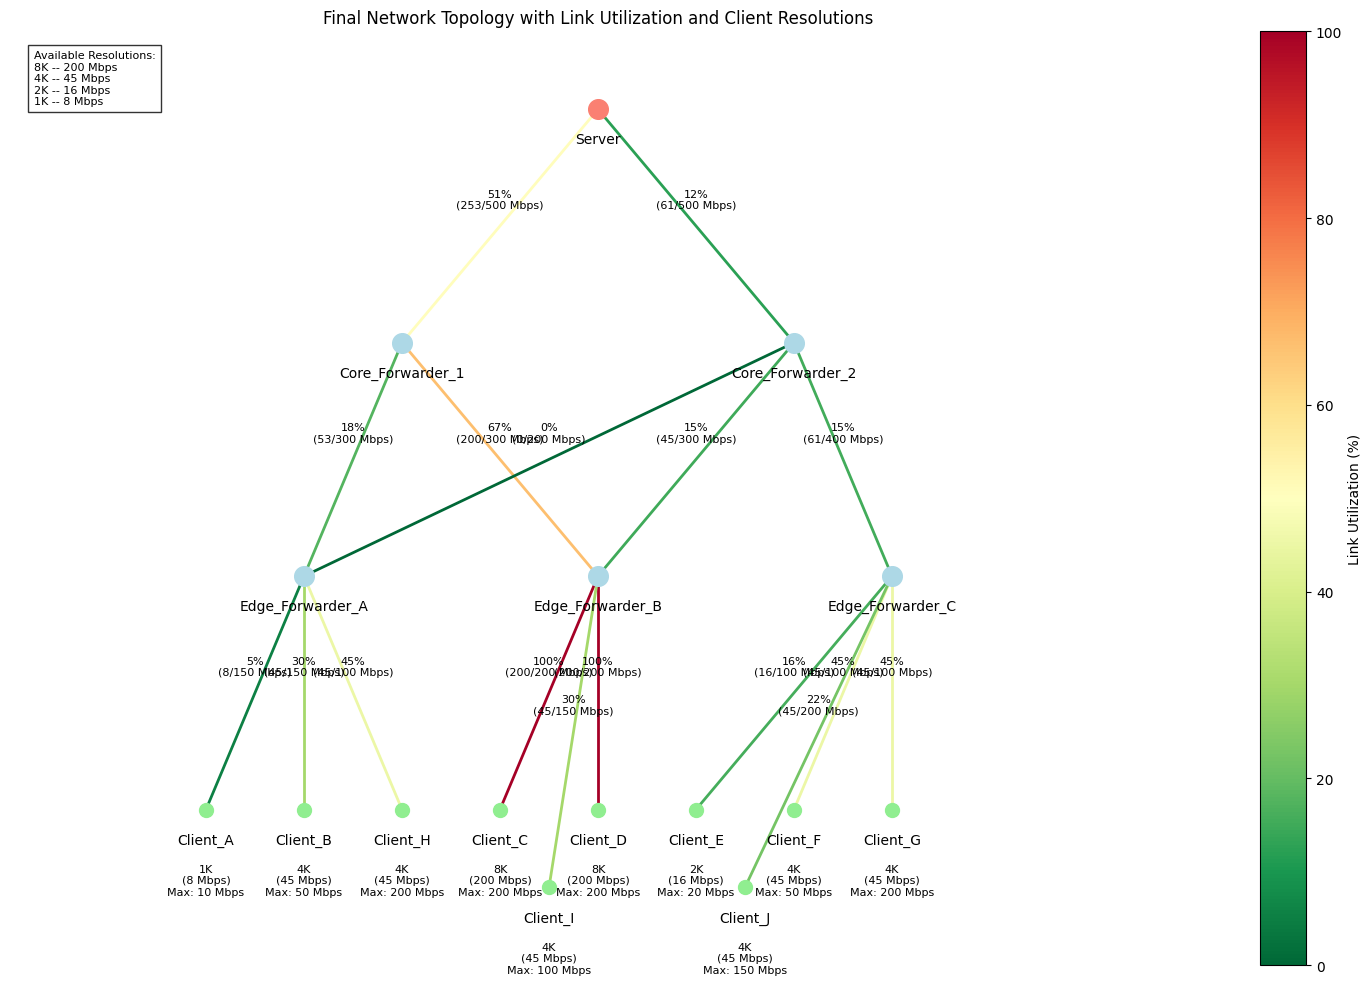


Final Client Assignments:
Client Resolution  Bandwidth  Max Bitrate  Utilization (%)
     A         1K          8           10             80.0
     B         4K         45           50             90.0
     C         8K        200          200            100.0
     D         8K        200          200            100.0
     E         2K         16           20             80.0
     F         4K         45           50             90.0
     G         4K         45          200             22.5
     H         4K         45          200             22.5
     I         4K         45          100             45.0
     J         4K         45          150             30.0


In [5]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt

def define_problem_data():
    # Resolution bandwidth requirements (Mbps)
    B = {
        '8K': 200,
        '4K': 45,
        '2K': 16,
        '1K': 8
    }

    # Quality scores for each resolution
    q = {
        '8K': 4,
        '4K': 3,
        '2K': 2,
        '1K': 1
    }

    # Client maximum bitrates
    max_bitrate = {
        'A': 10,
        'B': 50,
        'C': 200,
        'D': 200,
        'E': 20,
        'F': 50,
        'G': 200,
        'H': 200,
        'I': 100,
        'J': 150
    }

    # Link remaining estimated bandwidths (Mbps)
    links = {
        ('Server', 'Core_Forwarder_1'): 500,
        ('Server', 'Core_Forwarder_2'): 500,
        ('Core_Forwarder_1', 'Edge_Forwarder_A'): 300,
        ('Core_Forwarder_1', 'Edge_Forwarder_B'): 300,
        ('Core_Forwarder_2', 'Edge_Forwarder_A'): 200,
        ('Core_Forwarder_2', 'Edge_Forwarder_B'): 300,
        ('Core_Forwarder_2', 'Edge_Forwarder_C'): 400,
        ('Edge_Forwarder_A', 'Client_A'): 150,
        ('Edge_Forwarder_A', 'Client_B'): 150,
        ('Edge_Forwarder_B', 'Client_C'): 200,
        ('Edge_Forwarder_B', 'Client_D'): 200,
        ('Edge_Forwarder_C', 'Client_E'): 100,
        ('Edge_Forwarder_C', 'Client_F'): 100,
        ('Edge_Forwarder_C', 'Client_G'): 100,
        ('Edge_Forwarder_A', 'Client_H'): 100,
        ('Edge_Forwarder_B', 'Client_I'): 150,
        ('Edge_Forwarder_C', 'Client_J'): 200
    }

    # Client importance weights (default to 1 for all clients)
    weights = {client: 1 for client in max_bitrate.keys()}

    return B, q, max_bitrate, links, weights

class VideoOptimizationModel:
   def __init__(self, forwarder_name, clients, links, edge_results=None):
       self.forwarder_name = forwarder_name
       self.B, self.q, self.max_bitrate, self.all_links, self.weights = define_problem_data()
       self.clients = clients
       self.resolutions = list(self.B.keys())
       self.links = links
       self.edge_results = edge_results or {}  # Edge层结果
       self.model = None
       self.x = None
       self.create_model()

   def create_model(self):
       self.model = gp.Model(f"optimization_{self.forwarder_name}")
       # 决策变量：客户端i是否被分配分辨率j
       self.x = self.model.addVars(self.clients, self.resolutions, vtype=GRB.BINARY, name="x")

   def set_objective(self):
       # 最大化质量分数
       obj = gp.quicksum(self.weights[i] * self.q[j] * self.x[i, j] 
                        for i in self.clients for j in self.resolutions)
       self.model.setObjective(obj, GRB.MAXIMIZE)

   def add_constraints(self):
       """Add constraints for the model"""
       # 1. 每个客户端最多分配一个分辨率
       for i in self.clients:
           self.model.addConstr(
               gp.quicksum(self.x[i, j] for j in self.resolutions) <= 1,
               name=f"user_assignment_{i}"
           )

       # 2. 客户端带宽限制：不能超过客户端最大带宽
       for i in self.clients:
           for j in self.resolutions:
               if self.B[j] > self.max_bitrate[i]:
                   self.model.addConstr(
                       self.x[i, j] == 0,
                       name=f"user_capability_{i}_{j}"
                   )

       # 3. 链路带宽限制
       for (l, k), capacity in self.links.items():
           if 'Client_' in k:
               # 对于到客户端的链路，限制单个客户端的带宽使用
               client = k.split('_')[1]
               self.model.addConstr(
                   gp.quicksum(self.x[client, j] * self.B[j] 
                           for j in self.resolutions) <= capacity,
                   name=f"client_link_capacity_{client}"
               )
           else:
               # 对于转发器之间的链路，考虑多播特性
               use_resolution = self.model.addVars(
                   self.resolutions, vtype=GRB.BINARY,
                   name=f"use_resolution_{l}_{k}"
               )
               
               # 如果任何客户端使用某个分辨率，对应的use_resolution必须为1
               for j in self.resolutions:
                   for i in self.clients:
                       self.model.addConstr(
                           use_resolution[j] >= self.x[i, j],
                           name=f"resolution_usage_{l}_{k}_{j}_{i}"
                       )
               
               # 链路总带宽限制（考虑多播）
               self.model.addConstr(
                   gp.quicksum(use_resolution[j] * self.B[j] 
                           for j in self.resolutions) <= capacity,
                   name=f"link_capacity_{l}_{k}"
               )

       # 4. Core层必须满足Edge层的需求
       if 'Core_Forwarder' in self.forwarder_name and self.edge_results:
           for i in self.clients:
               for j in self.resolutions:
                   if (i, j) in self.edge_results:
                       self.model.addConstr(
                           self.x[i, j] >= self.edge_results[(i, j)],
                           name=f"edge_demand_{i}_{j}"
                       )

   def optimize(self):
       self.model.optimize()

   def get_results(self):
       """Return the results in terms of decision variables"""
       results = {(i, j): self.x[i, j].x 
                 for i in self.clients 
                 for j in self.resolutions 
                 if self.x[i, j].x > 0.5}
       return results

   def print_results(self):
       """Print results"""
       if self.model.status == GRB.OPTIMAL:
           print(f"\nResults for {self.forwarder_name}:")
           for (i, j), value in self.get_results().items():
               print(f"Client {i} assigned resolution {j} (x={value})")
       else:
           print(f"No optimal solution found for {self.forwarder_name}.")

def plot_final_results(all_results):
    """Plot final network topology with all results"""
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Define node positions
    pos = {
        'Server': (0.5, 1.0),
        'Core_Forwarder_1': (0.3, 0.7),
        'Core_Forwarder_2': (0.7, 0.7),
        'Edge_Forwarder_A': (0.2, 0.4),
        'Edge_Forwarder_B': (0.5, 0.4),
        'Edge_Forwarder_C': (0.8, 0.4)
    }
    
    # Add client positions
    client_positions = {
        'A': (0.1, 0.1), 'B': (0.2, 0.1), 'C': (0.4, 0.1),
        'D': (0.5, 0.1), 'E': (0.6, 0.1), 'F': (0.7, 0.1),
        'G': (0.8, 0.1), 'H': (0.3, 0.1), 'I': (0.45, 0.0),
        'J': (0.65, 0.0)
    }
    pos.update({f'Client_{client}': position for client, position in client_positions.items()})

    # Get problem data
    B, q, max_bitrate, links, weights = define_problem_data()
    
    # Initialize link usage dictionary
    link_usage = {}
    for link in links.keys():
        link_usage[link] = 0

    # Define client paths through the network
    client_paths = {
        'A': [('Server', 'Core_Forwarder_1'), ('Core_Forwarder_1', 'Edge_Forwarder_A'), ('Edge_Forwarder_A', 'Client_A')],
        'B': [('Server', 'Core_Forwarder_1'), ('Core_Forwarder_1', 'Edge_Forwarder_A'), ('Edge_Forwarder_A', 'Client_B')],
        'C': [('Server', 'Core_Forwarder_1'), ('Core_Forwarder_1', 'Edge_Forwarder_B'), ('Edge_Forwarder_B', 'Client_C')],
        'D': [('Server', 'Core_Forwarder_1'), ('Core_Forwarder_1', 'Edge_Forwarder_B'), ('Edge_Forwarder_B', 'Client_D')],
        'E': [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_C'), ('Edge_Forwarder_C', 'Client_E')],
        'F': [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_C'), ('Edge_Forwarder_C', 'Client_F')],
        'G': [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_C'), ('Edge_Forwarder_C', 'Client_G')],
        'H': [('Server', 'Core_Forwarder_1'), ('Core_Forwarder_1', 'Edge_Forwarder_A'), ('Edge_Forwarder_A', 'Client_H')],
        'I': [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_B'), ('Edge_Forwarder_B', 'Client_I')],
        'J': [('Server', 'Core_Forwarder_2'), ('Core_Forwarder_2', 'Edge_Forwarder_C'), ('Edge_Forwarder_C', 'Client_J')]
    }

    # Create dictionary to store final client assignments
    final_assignments = {}
    # First get edge forwarder results (they take precedence)
    for forwarder_name, results in all_results.items():
        if 'Edge_Forwarder' in forwarder_name:
            for (client, res), value in results.items():
                if value > 0.5:
                    final_assignments[client] = res

    # Update link usage based on final assignments and paths
    unique_resolutions_per_link = {}
    for link in links:
        unique_resolutions_per_link[link] = set()

    for client_id, path in client_paths.items():
        resolution = final_assignments.get(client_id)
        if resolution:
            bandwidth = B[resolution]
            for link in path:
                if link in links:
                    # 对于每条链路，记录通过的分辨率
                    unique_resolutions_per_link[link].add(resolution)
                    
    # 计算每条链路的实际带宽使用
    for link in links:
        # 链路带宽使用为该链路上所有唯一分辨率的带宽之和
        link_usage[link] = sum(B[res] for res in unique_resolutions_per_link[link])

    # Plot nodes and links
    for node, (x, y) in pos.items():
        if 'Client' in node:
            color = 'lightgreen'
            size = 100
            client_id = node.split('_')[1]
            resolution = final_assignments.get(client_id)
            
            ax.scatter(x, y, c=color, s=size, zorder=2)
            ax.text(x, y-0.03, node, ha='center', va='top')
            if resolution:
                bandwidth = B[resolution]
                ax.text(x, y-0.07, f'{resolution}\n({bandwidth} Mbps)\nMax: {max_bitrate[client_id]} Mbps',
                       ha='center', va='top', fontsize=8)
        
        elif 'Forwarder' in node:
            color = 'lightblue'
            size = 200
            ax.scatter(x, y, c=color, s=size, zorder=2)
            ax.text(x, y-0.03, node, ha='center', va='top')
        
        else:  # Server
            color = 'salmon'
            size = 200
            ax.scatter(x, y, c=color, s=size, zorder=2)
            ax.text(x, y-0.03, node, ha='center', va='top')
    
    # Plot links with utilization colors
    for (l, k), capacity in links.items():
        if l in pos and k in pos:
            start_pos = pos[l]
            end_pos = pos[k]
            
            usage = link_usage.get((l, k), 0)
            utilization = (usage / capacity) * 100
            color = plt.cm.RdYlGn_r(utilization / 100)
            
            ax.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]],
                   color=color, linewidth=2, zorder=1)
            
            mid_x = (start_pos[0] + end_pos[0]) / 2
            mid_y = (start_pos[1] + end_pos[1]) / 2
            ax.text(mid_x, mid_y+0.02, f'{round(utilization)}%\n({round(usage)}/{capacity} Mbps)',
                   ha='center', va='bottom', fontsize=8)
    
    # Add color bar for utilization
    norm = plt.Normalize(0, 100)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r, norm=norm)
    plt.colorbar(sm, ax=ax, label='Link Utilization (%)')
    
    # Add resolution legend
    resolutions = [('8K', 200), ('4K', 45), ('2K', 16), ('1K', 8)]
    legend_text = 'Available Resolutions:\n' + '\n'.join(f'{res} -- {bw} Mbps' for res, bw in resolutions)
    ax.text(0.02, 0.98, legend_text, transform=ax.transAxes,
            ha='left', va='top', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))
    
    # Set title and layout
    ax.set_title('Final Network Topology with Link Utilization and Client Resolutions')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Print tabulated results
    print("\nFinal Client Assignments:")
    results_table = []
    for client_id, resolution in final_assignments.items():
       results_table.append({
           'Client': client_id,
           'Resolution': resolution,
           'Bandwidth': B[resolution],
           'Max Bitrate': max_bitrate[client_id],
           'Utilization (%)': round(B[resolution] / max_bitrate[client_id] * 100, 1)
       })
    
    df_results = pd.DataFrame(results_table)
    # Sort results by client ID
    df_results = df_results.sort_values('Client')
    print(df_results.to_string(index=False))

def run_distributed_optimization():
    # Define the clients for each forwarder
    forwarder_clients = {
        "Core_Forwarder_1": ['A', 'B', 'C', 'D', 'H'],
        "Core_Forwarder_2": ['E', 'F', 'G', 'I', 'J'],
        "Edge_Forwarder_A": ['A', 'B', 'H'],
        "Edge_Forwarder_B": ['C', 'D', 'I'],
        "Edge_Forwarder_C": ['E', 'F', 'G', 'J']
    }

    # Define links for each forwarder
    forwarder_links = {
        "Core_Forwarder_1": {('Server', 'Core_Forwarder_1'): 500},
        "Core_Forwarder_2": {('Server', 'Core_Forwarder_2'): 500},
        "Edge_Forwarder_A": {
            ('Core_Forwarder_1', 'Edge_Forwarder_A'): 300,
            ('Edge_Forwarder_A', 'Client_A'): 150,
            ('Edge_Forwarder_A', 'Client_B'): 150,
            ('Edge_Forwarder_A', 'Client_H'): 100
        },
        "Edge_Forwarder_B": {
            ('Core_Forwarder_1', 'Edge_Forwarder_B'): 300,
            ('Edge_Forwarder_B', 'Client_C'): 200,
            ('Edge_Forwarder_B', 'Client_D'): 200,
            ('Edge_Forwarder_B', 'Client_I'): 150
        },
        "Edge_Forwarder_C": {
            ('Core_Forwarder_2', 'Edge_Forwarder_C'): 400,
            ('Edge_Forwarder_C', 'Client_E'): 100,
            ('Edge_Forwarder_C', 'Client_F'): 100,
            ('Edge_Forwarder_C', 'Client_G'): 100,
            ('Edge_Forwarder_C', 'Client_J'): 200
        }
    }

    # Step 1: Edge Forwarders Optimization
    edge_forwarder_a = VideoOptimizationModel(
        "Edge_Forwarder_A",
        forwarder_clients["Edge_Forwarder_A"],
        forwarder_links["Edge_Forwarder_A"]
    )
    edge_forwarder_a.set_objective()
    edge_forwarder_a.add_constraints()
    edge_forwarder_a.optimize()
    edge_results_a = edge_forwarder_a.get_results()
    edge_forwarder_a.print_results()

    edge_forwarder_b = VideoOptimizationModel(
        "Edge_Forwarder_B",
        forwarder_clients["Edge_Forwarder_B"],
        forwarder_links["Edge_Forwarder_B"]
    )
    edge_forwarder_b.set_objective()
    edge_forwarder_b.add_constraints()
    edge_forwarder_b.optimize()
    edge_results_b = edge_forwarder_b.get_results()
    edge_forwarder_b.print_results()

    edge_forwarder_c = VideoOptimizationModel(
        "Edge_Forwarder_C",
        forwarder_clients["Edge_Forwarder_C"],
        forwarder_links["Edge_Forwarder_C"]
    )
    edge_forwarder_c.set_objective()
    edge_forwarder_c.add_constraints()
    edge_forwarder_c.optimize()
    edge_results_c = edge_forwarder_c.get_results()
    edge_forwarder_c.print_results()

    # Step 2: Core Forwarders Optimization
    # 合并Edge A和B的结果给Core 1
    edge_results_for_core1 = {**edge_results_a, **edge_results_b}
    core_forwarder_1 = VideoOptimizationModel(
        "Core_Forwarder_1",
        forwarder_clients["Core_Forwarder_1"],
        forwarder_links["Core_Forwarder_1"],
        edge_results_for_core1
    )
    core_forwarder_1.set_objective()
    core_forwarder_1.add_constraints()
    core_forwarder_1.optimize()
    core_forwarder_1.print_results()

    # 合并Edge C的结果给Core 2
    edge_results_for_core2 = {**edge_results_c}
    core_forwarder_2 = VideoOptimizationModel(
        "Core_Forwarder_2",
        forwarder_clients["Core_Forwarder_2"],
        forwarder_links["Core_Forwarder_2"],
        edge_results_for_core2
    )
    core_forwarder_2.set_objective()
    core_forwarder_2.add_constraints()
    core_forwarder_2.optimize()
    core_forwarder_2.print_results()

    # Collect all results
    all_results = {
        'Edge_Forwarder_A': edge_results_a,
        'Edge_Forwarder_B': edge_results_b,
        'Edge_Forwarder_C': edge_results_c,
        'Core_Forwarder_1': core_forwarder_1.get_results(),
        'Core_Forwarder_2': core_forwarder_2.get_results()
    }
    
    # Plot final results
    plot_final_results(all_results)

if __name__ == "__main__":
    run_distributed_optimization()


# Code Implementation Analysis

## Overview
This implementation provides a scalability analysis framework for our distributed video optimization system. The code simulates and evaluates how the system performs with increasing numbers of users, demonstrating the effectiveness of our hierarchical optimization approach.

## Implementation 

### 1. Network Topology Generation
The system dynamically generates a hierarchical network topology based on the number of users:

- **Edge Layer Scaling**:
  - Each Edge forwarder manages ~50 users
  - Number of Edge forwarders = ceil(num_users / 50)

- **Core Layer Scaling**:
  - Each Core forwarder manages ~10 Edge forwarders
  - Number of Core forwarders = ceil(num_edge / 10)

- **Link Capacities**:
  - Server → Core: 800 Mbps
  - Core → Edge: 300 Mbps
  - Edge → Client: Randomly assigned {100, 150, 200} Mbps

### 2. Optimization Process

The optimization follows a bottom-up approach:

1. **Edge Layer Optimization**
   - Processes batches of 50 users independently
   - Considers individual user constraints and preferences
   - Optimizes video resolution assignments for local user groups

2. **Core Layer Optimization**
   - Aggregates results from Edge forwarders
   - Ensures bandwidth constraints across the network
   - Implements multicast optimization
   - Maintains consistency with Edge layer decisions

### 3. Performance Metrics
The implementation tracks several key metrics:
- Edge layer optimization time
- Core layer optimization time
- Total optimization time


### Performance Results
- Shows linear scaling in optimization time with user count

### Current Limitation
The implementation has a practical limitation due to the Gurobi license restrictions:
- Maximum testable user count: ~300 users
- Error message when exceeded: "Model too large for size-limited license"

However, this limitation doesn't affect the validity of our analysis, as we can already observe the scaling patterns within this range.



Analyzing scale: 100 users
Restricted license - for non-production use only - expires 2026-11-23
Optimizing Core Forwarder 1...

Edge layer optimization took 0.081 seconds.
Core layer optimization took 0.014 seconds.
Total optimization time for 100 users: 0.095 seconds.


Analyzing scale: 200 users
Optimizing Core Forwarder 1...

Edge layer optimization took 0.330 seconds.
Core layer optimization took 0.016 seconds.
Total optimization time for 200 users: 0.347 seconds.


Analyzing scale: 300 users
Optimizing Core Forwarder 1...

Edge layer optimization took 0.491 seconds.
Core layer optimization took 0.025 seconds.
Total optimization time for 300 users: 0.516 seconds.


Analyzing scale: 350 users
Optimizing Core Forwarder 1...

Edge layer optimization took 0.656 seconds.
Core layer optimization took 0.030 seconds.
Total optimization time for 350 users: 0.686 seconds.



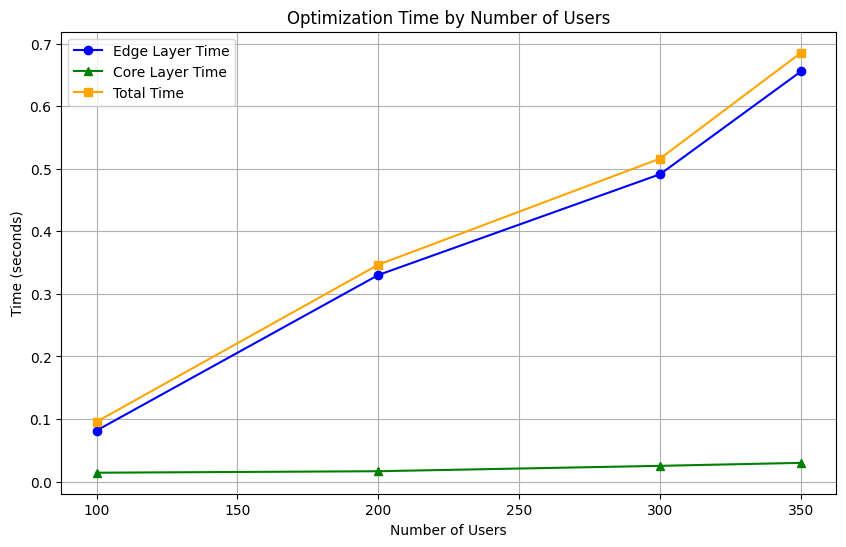


Performance Summary:
   num_users  total_time  edge_time  core_time   status
0        100    0.095494   0.081456   0.014036  Success
1        200    0.346621   0.330176   0.016444  Success
2        300    0.516401   0.491354   0.025046  Success
3        350    0.685577   0.655763   0.029814  Success


In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Define problem data
def define_problem_data(num_users):
    B = {'8K': 200, '4K': 45, '2K': 16, '1K': 8}  # Bandwidth requirements
    q = {'8K': 4, '4K': 3, '2K': 2, '1K': 1}  # Quality scores
  
    max_bitrate = {f'Client_User_{i}': np.random.choice([10, 50, 200]) for i in range(num_users)}
    weights = {f'Client_User_{i}': 1 for i in range(num_users)}  # Equal weights for all users
    links = generate_network_topology(num_users)
    return B, q, max_bitrate, links, weights

# Generate network topology dynamically
def generate_network_topology(num_users):
    links = {}
    num_edge = max(num_users // 50, 1)  # Each Edge forwarder handles ~50 users
    num_core = max(num_edge // 10, 1)  # Each Core forwarder handles ~10 Edge forwarders

    # Server to Core
    for i in range(num_core):
        links[('Server', f'Core_Forwarder_{i}')] = 800

    # Core to Edge
    for i in range(num_edge):
        core_id = i % num_core
        links[(f'Core_Forwarder_{core_id}', f'Edge_Forwarder_{i}')] = 300

    # Edge to Client
    for i in range(num_users):
        client_id = f'User_{i}'
        edge_id = i // 50
        links[(f'Edge_Forwarder_{edge_id}', f'Client_User_{client_id}')] = np.random.choice([100, 150, 200])

    return links

class VideoOptimizationModel:
    def __init__(self, forwarder_name, clients, problem_data, lower_layer_results=None):
        self.forwarder_name = forwarder_name
        self.clients = clients
        self.B, self.q, self.max_bitrate, self.links, self.weights = problem_data
        self.resolutions = list(self.B.keys())
        self.lower_layer_results = lower_layer_results or {}
        self.model = None
        self.x = None
        self.use_resolution = {}  # For multicast constraints
        self.create_model()

    def create_model(self):
        self.model = gp.Model(f"optimization_{self.forwarder_name}")
        self.model.setParam('OutputFlag', 0)  # Disable solver output
        self.x = self.model.addVars(self.clients, self.resolutions, vtype=GRB.BINARY, name="x")

    def set_objective(self):
        obj = gp.quicksum(self.weights[i] * self.q[j] * self.x[i, j]
                          for i in self.clients for j in self.resolutions)
        self.model.setObjective(obj, GRB.MAXIMIZE)

    def add_constraints(self):
        # Each client can only get one resolution
        for i in self.clients:
            self.model.addConstr(
                gp.quicksum(self.x[i, j] for j in self.resolutions) <= 1,
                name=f"single_resolution_{i}"
            )

        # Client bandwidth limits
        for i in self.clients:
            for j in self.resolutions:
                if self.B[j] > self.max_bitrate[i]:
                    self.model.addConstr(self.x[i, j] == 0, name=f"bandwidth_limit_{i}_{j}")

        # Link capacity constraints
        for (l, k), capacity in self.links.items():
            if k in self.clients:
                # Client link: simple sum of bandwidths
                client = k  # 'Client_User_0' or 'Edge_Forwarder_0'
                self.model.addConstr(
                    gp.quicksum(self.x[client, j] * self.B[j] for j in self.resolutions) <= capacity,
                    name=f"link_capacity_{l}_{k}"
                )
            else:
                # Forwarder link: multicast constraints
                # Introduce binary variables to indicate if a resolution is used on this link
                for j in self.resolutions:
                    var = self.model.addVar(vtype=GRB.BINARY, name=f"use_resolution_{l}_{k}_{j}")
                    self.use_resolution[(l, k, j)] = var
                    # Link usage for resolution j must be >= any client's usage
                    self.model.addConstr(
                        var >= gp.quicksum(self.x[i, j] for i in self.clients if i in self.clients),
                        name=f"multicast_usage_{l}_{k}_{j}"
                    )
                # Total bandwidth used on the link
                self.model.addConstr(
                    gp.quicksum(self.use_resolution[(l, k, j)] * self.B[j] for j in self.resolutions) <= capacity,
                    name=f"multicast_capacity_{l}_{k}"
                )

        # Lower layer results
        for (client, resolution), value in self.lower_layer_results.items():
            if client in self.clients and resolution in self.resolutions:
                self.model.addConstr(
                    self.x[client, resolution] >= value,
                    name=f"lower_layer_demand_{client}_{resolution}"
                )

    def optimize(self):
        self.set_objective()
        self.add_constraints()
        self.model.optimize()

    def get_results(self):
        if self.model.status == GRB.OPTIMAL:
            return {(i, j): self.x[i, j].x
                    for i in self.clients
                    for j in self.resolutions
                    if self.x[i, j].x > 0.5}
        return {}

class DistributedPerformanceAnalyzer:
    def __init__(self):
        self.results = []

    def analyze_scale(self, num_users):
        problem_data = define_problem_data(num_users)
        B, q, max_bitrate, links, weights = problem_data
        clients = [f'Client_User_{i}' for i in range(num_users)]  # Ensure consistent naming

        # Split clients into regions (Edge forwarders)
        regions = [clients[i:i + 50] for i in range(0, len(clients), 50)]
        edge_results = {}

        start_time = time.time()

        # Optimize Edge layer
        edge_start_time = time.time()
        for region_id, region_clients in enumerate(regions):
            model = VideoOptimizationModel(f"Edge_Forwarder_{region_id}", region_clients, problem_data)
            model.optimize()
            edge_results[f"Edge_Forwarder_{region_id}"] = model.get_results()
        edge_time = time.time() - edge_start_time

        # Optimize Core layer
        core_results = {}
        core_start_time = time.time()
        num_core = max(len(regions) // 10, 1)
        for core_id in range(num_core):
            print(f"Optimizing Core Forwarder {core_id + 1}...")
            # Determine which edges are managed by this core
            managed_edges = [f"Edge_Forwarder_{i}" for i in range(len(regions)) if i % num_core == core_id]
            # Extract traffic demands from edge_results
            lower_layer_results = {}
            for edge in managed_edges:
                results = edge_results.get(edge, {})
                for (client, res), value in results.items():
                    if value > 0.5:
                        lower_layer_results[(edge, res)] = value

            # Calculate weights_core and max_bitrate_core based on lower_layer_results
            weights_core = {}
            max_bitrate_core = {}
            for (edge, res), value in lower_layer_results.items():
                weights_core[edge] = weights_core.get(edge, 0) + q[res]
                max_bitrate_core[edge] = max_bitrate_core.get(edge, 0) + B[res]

            # Create problem data for core layer
            problem_data_core = (B, q, max_bitrate_core, links, weights_core)

            # Populate core_lower_layer with (edge, resolution): value
            core_lower_layer = lower_layer_results.copy()

            # Optimize core forwarder
            model = VideoOptimizationModel(
                forwarder_name=f"Core_Forwarder_{core_id}",
                clients=managed_edges,
                problem_data=problem_data_core,
                lower_layer_results=core_lower_layer
            )
            model.optimize()
            core_results[f"Core_Forwarder_{core_id}"] = model.get_results()
        core_time = time.time() - core_start_time

        total_time = time.time() - start_time

        print(f"\nEdge layer optimization took {edge_time:.3f} seconds.")
        print(f"Core layer optimization took {core_time:.3f} seconds.")
        print(f"Total optimization time for {num_users} users: {total_time:.3f} seconds.\n")

        return {
            'num_users': num_users,
            'total_time': total_time,
            'edge_time': edge_time,
            'core_time': core_time,
            'status': 'Success',
        }

    def run_analysis(self, user_scales):
        summary = []
        for num_users in user_scales:
            print(f"\nAnalyzing scale: {num_users} users")
            result = self.analyze_scale(num_users)
            self.results.append(result)
            summary.append(result)

        self.plot_results(summary)

    def plot_results(self, summary):
        df = pd.DataFrame(summary)

        # Plot edge time, core time, and total time
        plt.figure(figsize=(10, 6))
        plt.plot(df['num_users'], df['edge_time'], label='Edge Layer Time', marker='o', color='blue')
        plt.plot(df['num_users'], df['core_time'], label='Core Layer Time', marker='^', color='green')
        plt.plot(df['num_users'], df['total_time'], label='Total Time', marker='s', color='orange')
        plt.title('Optimization Time by Number of Users')
        plt.xlabel('Number of Users')
        plt.ylabel('Time (seconds)')
        plt.grid(True)
        plt.legend()
        plt.show()

        print("\nPerformance Summary:")
        print(df)

def main():
    analyzer = DistributedPerformanceAnalyzer()
    user_scales = [100, 200, 300,350]
    analyzer.run_analysis(user_scales)

if __name__ == "__main__":
    main()


In [23]:
!jupyter nbconvert --to pdf model.ipynb

[NbConvertApp] Converting notebook model.ipynb to pdf
[NbConvertApp] Writing 2020557 bytes to model.pdf


# Scalability Analysis (for centralized model)


Analyzing user count: 8


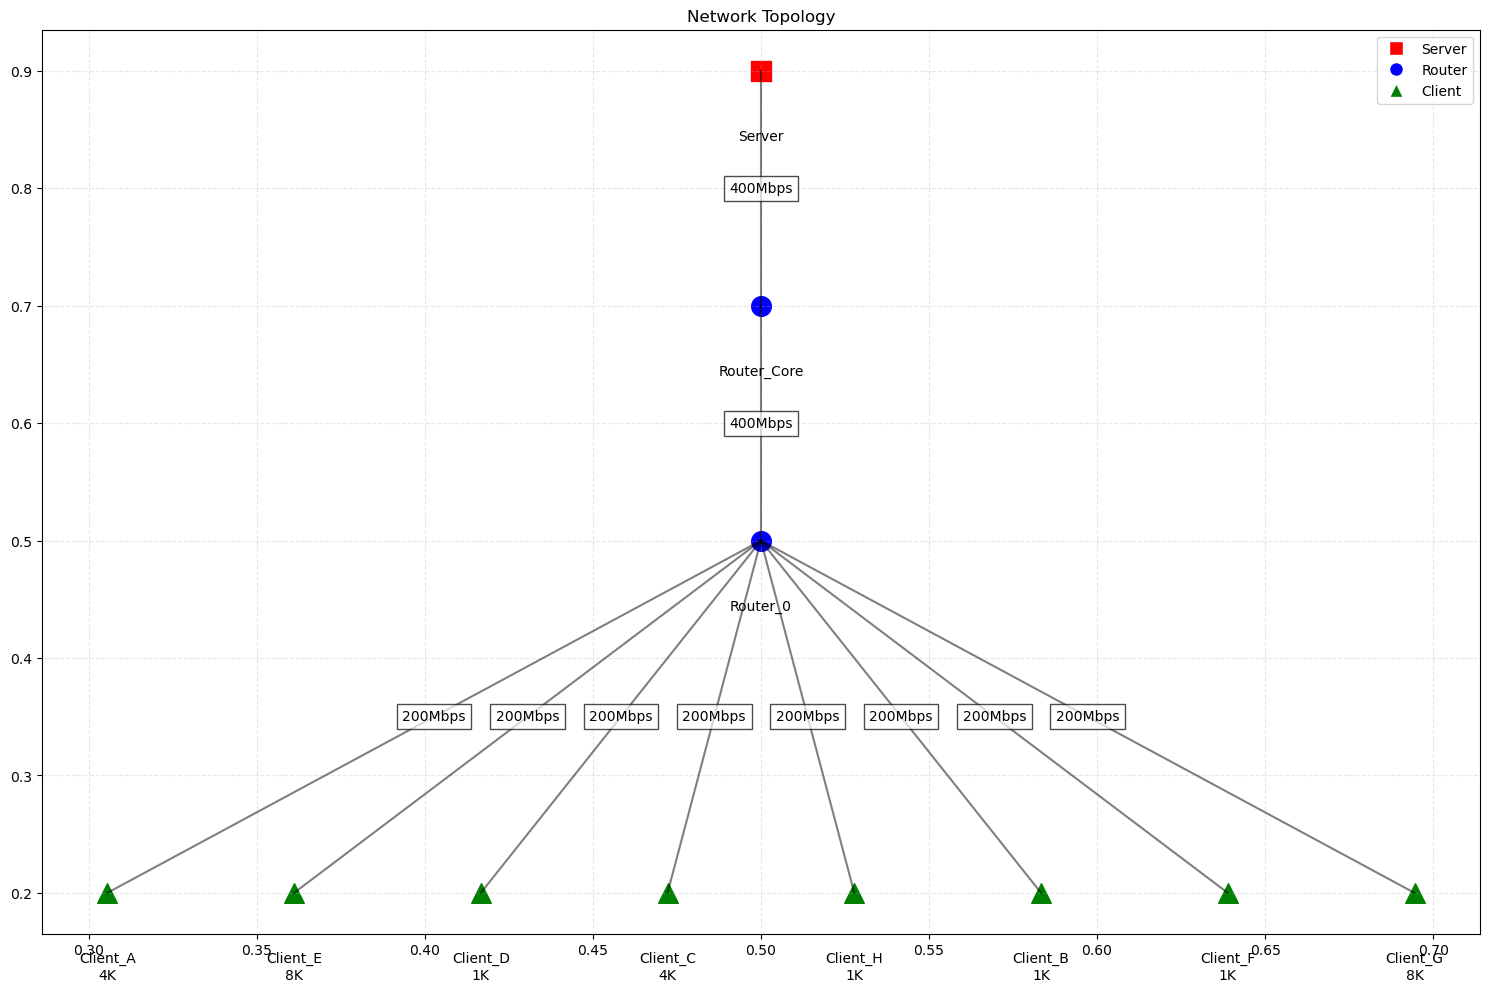

Solution status: Success
Completed - Total time: 0.00s

Analyzing user count: 16


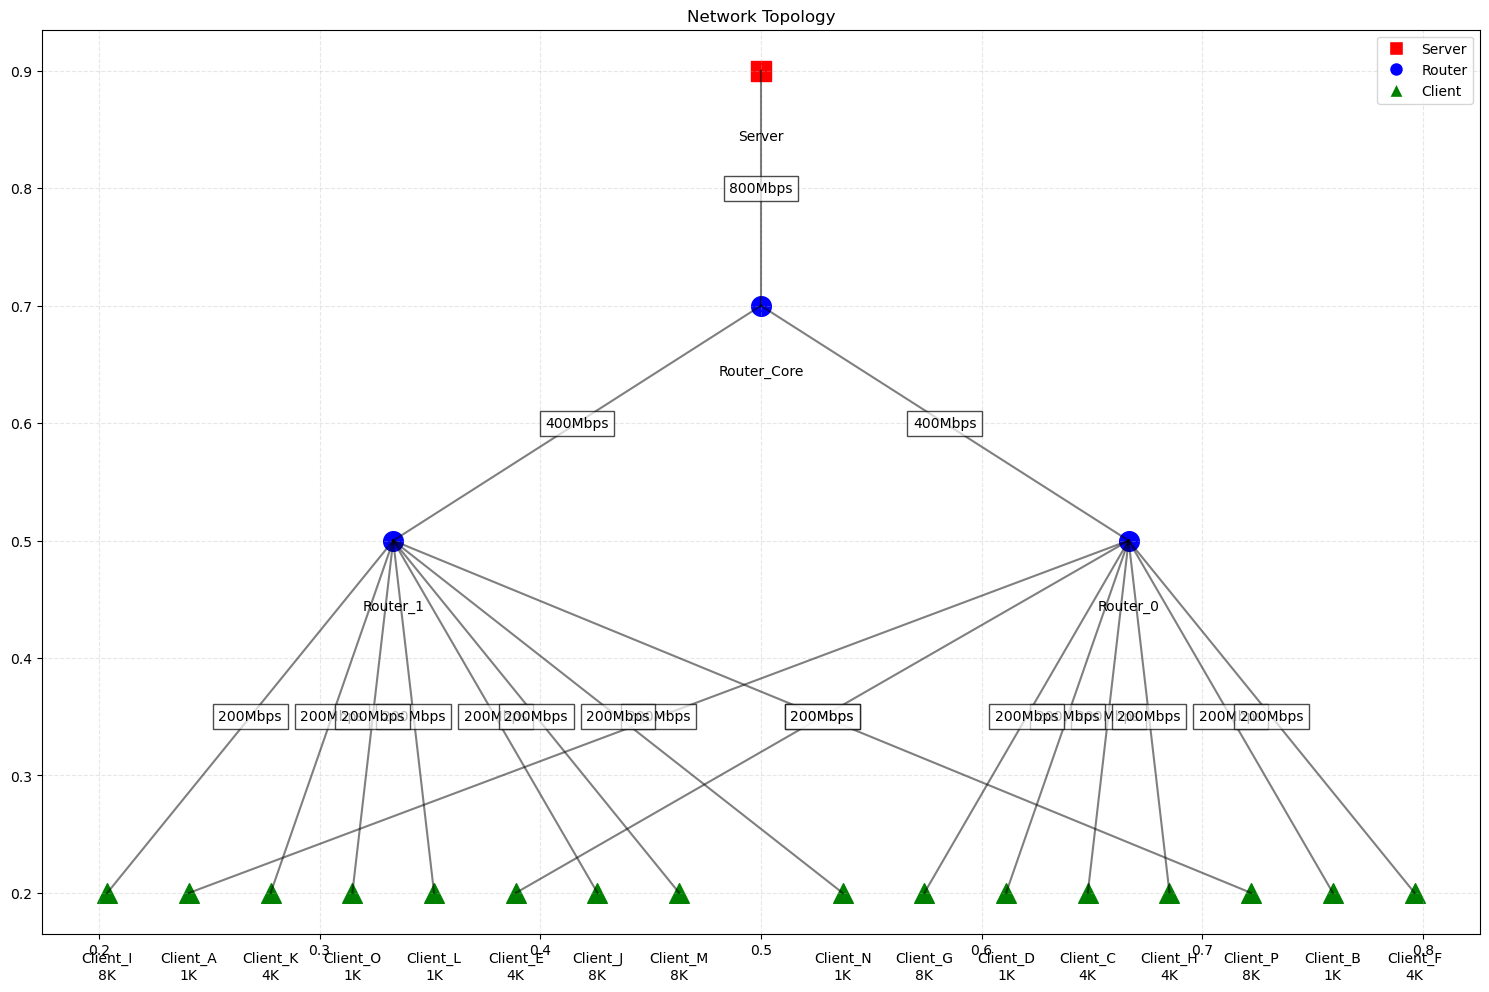

Solution status: Success
Completed - Total time: 0.00s

Analyzing user count: 32


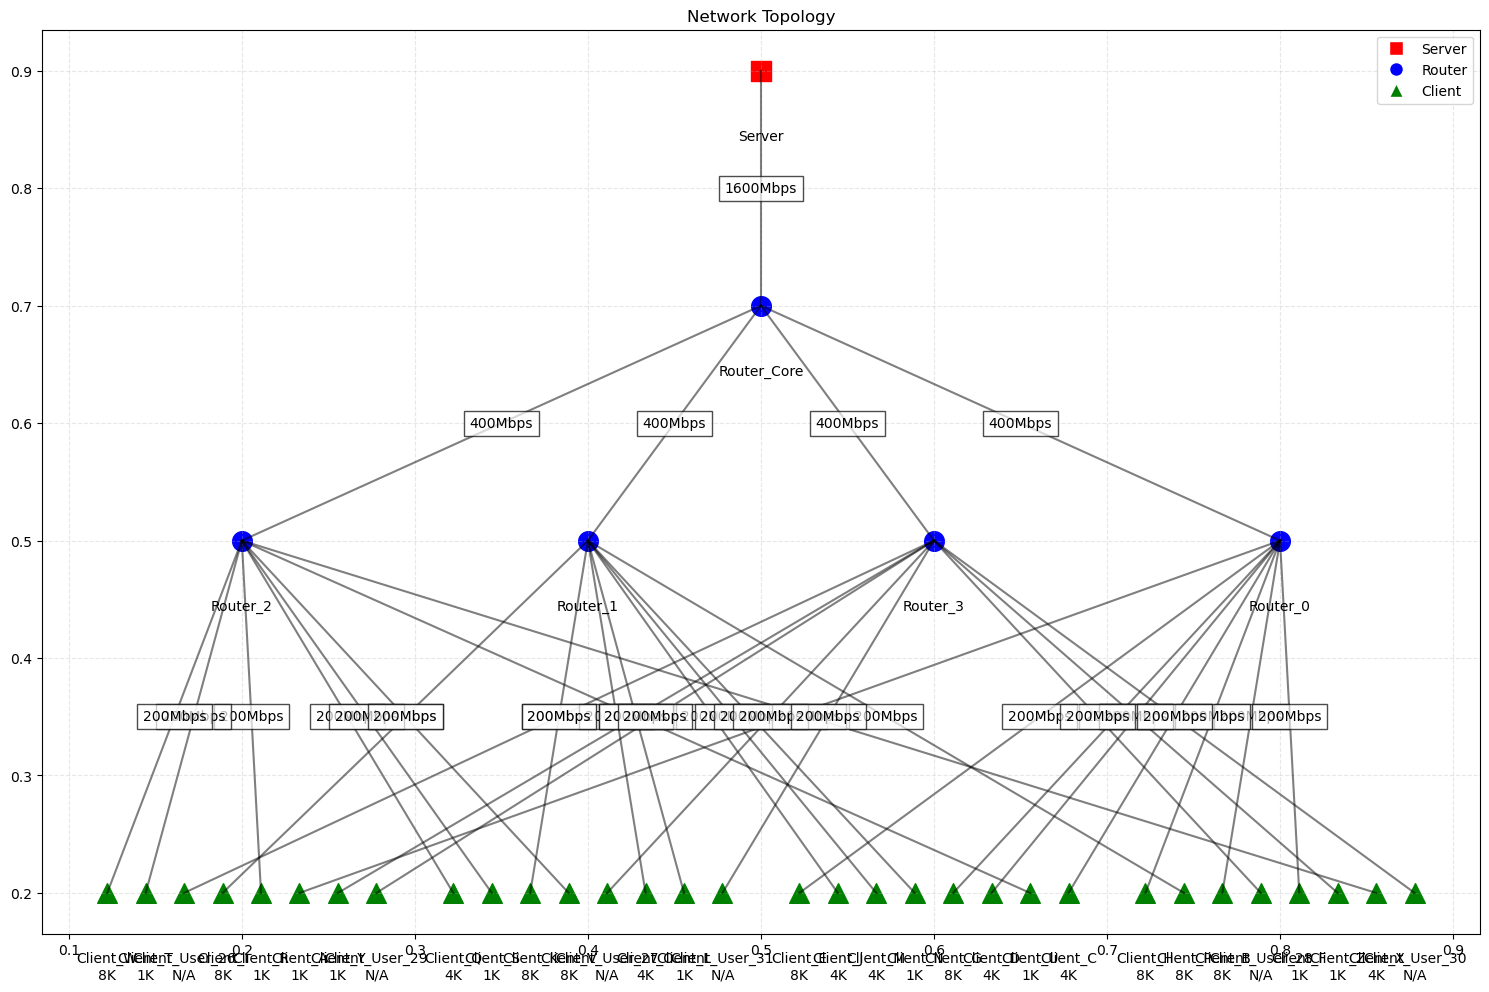

Solution status: Success
Completed - Total time: 0.01s

Analyzing user count: 64


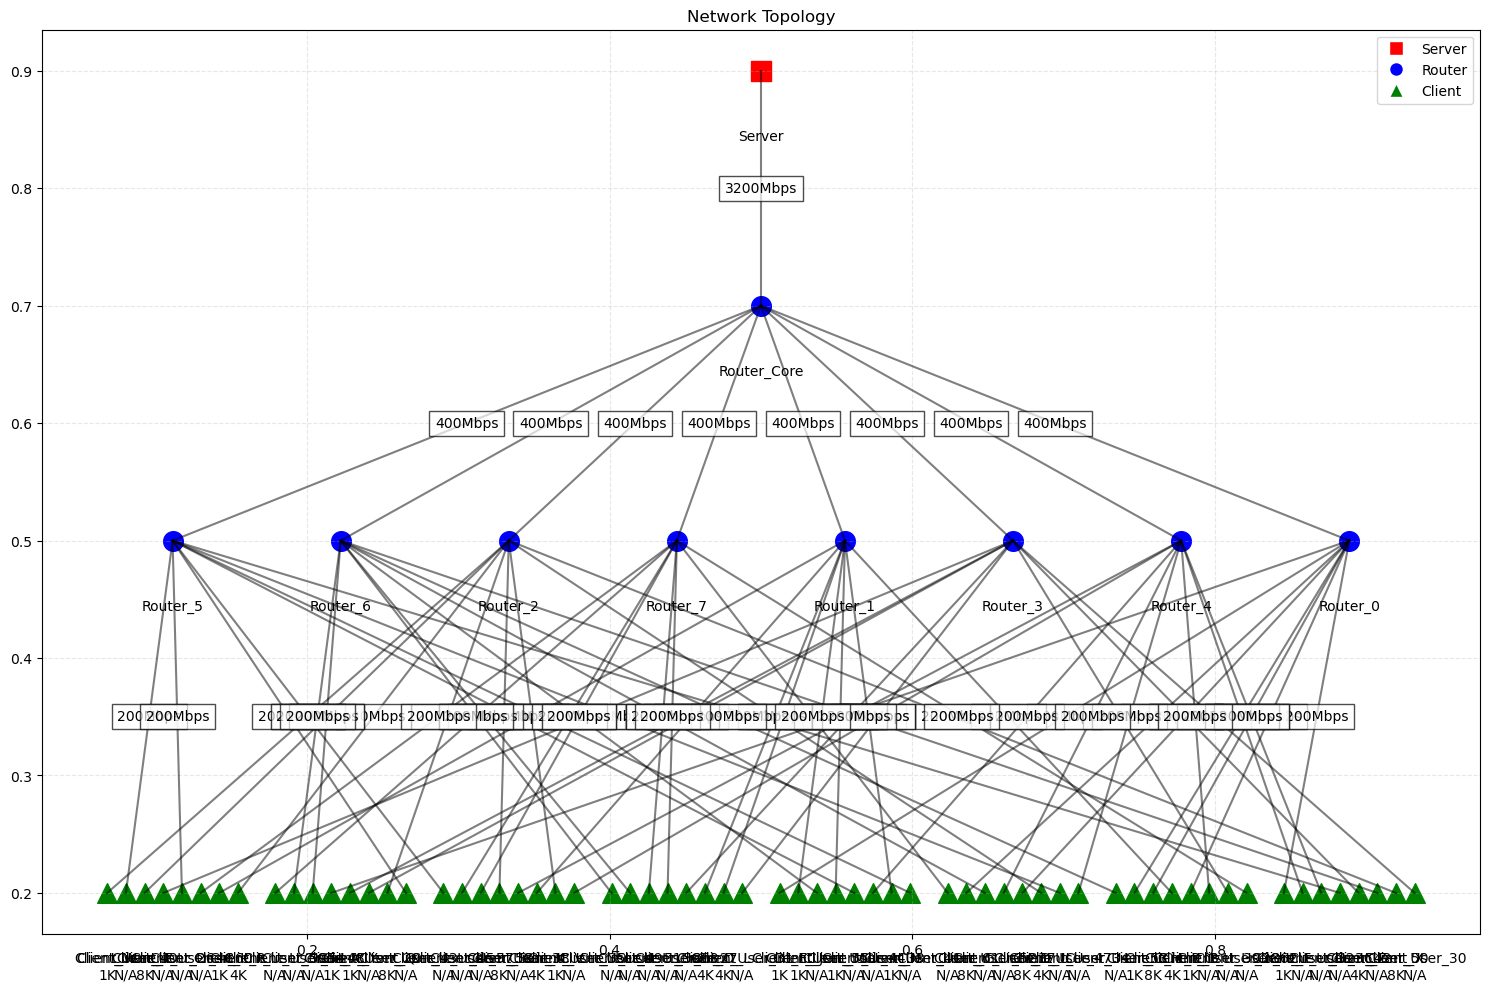

Solution status: Success
Completed - Total time: 0.01s

Analyzing user count: 128


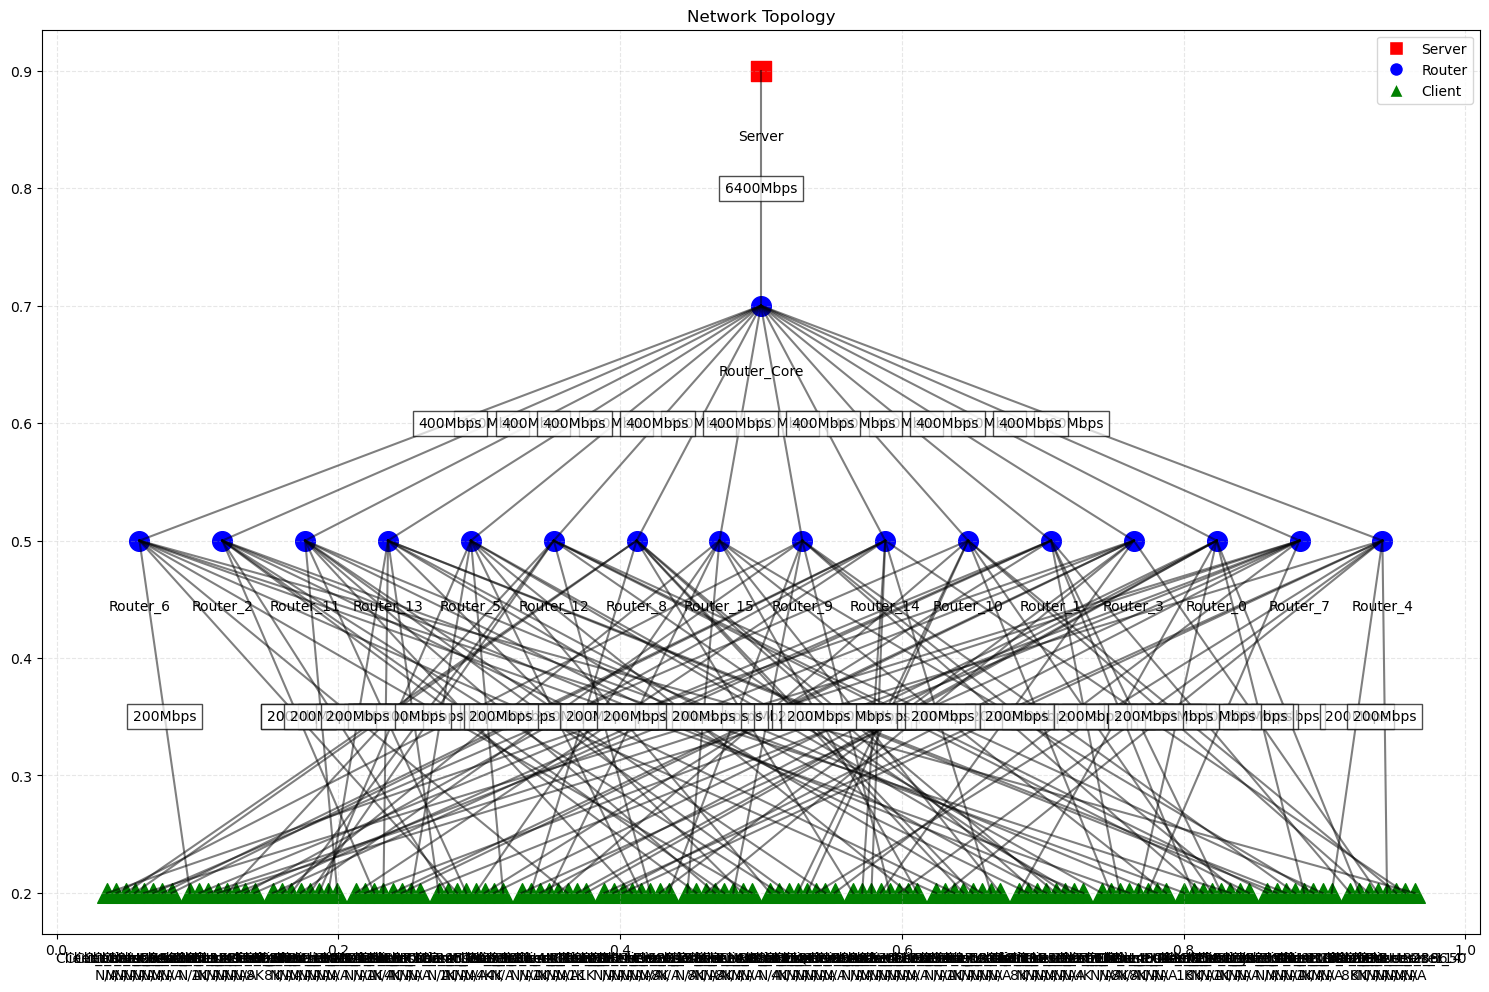

Solution status: Success
Completed - Total time: 0.03s

Performance Analysis Results:
   num_users  num_variables  num_constraints  setup_time  solve_time  total_time  objective_value  model_status   status
0          8             90              138    0.003630       0.001    0.004630            -22.0             2  Success
1         16            175              269    0.002888       0.001    0.003888            -49.0             2  Success
2         32            345              537    0.004997       0.001    0.005997            -97.0             2  Success
3         64            685             1071    0.010005       0.001    0.011005           -195.0             2  Success
4        128           1365             2111    0.029518       0.002    0.031518           -419.0             2  Success


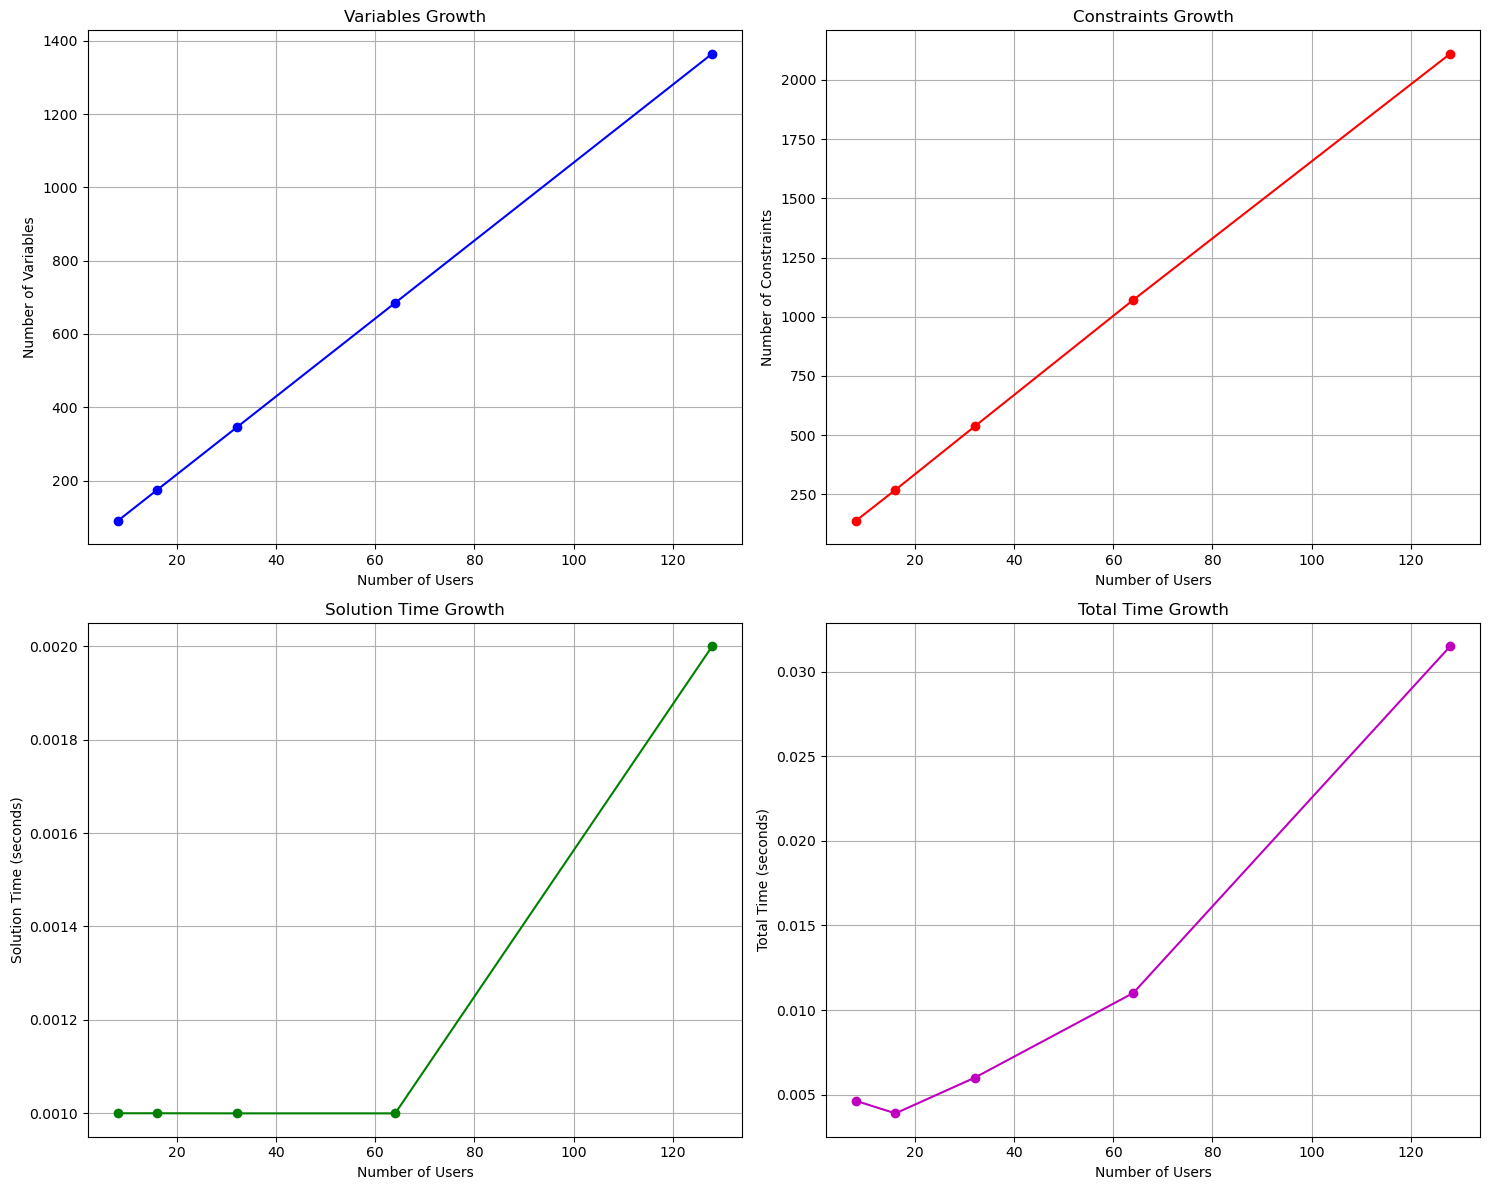

In [22]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
import time
import numpy as np
from typing import Dict, List, Tuple

class ScalabilityAnalysis:
    def __init__(self):
        # Base video resolution and quality parameters
        self.B = {
            '8K': 200,
            '4K': 45,
            '2K': 16,
            '1K': 8
        }
        self.q = {
            '8K': 4,
            '4K': 3,
            '2K': 2,
            '1K': 1
        }
        
    def generate_network(self, num_users: int) -> Tuple[Dict, Dict, Dict]:
        """
        Generate network topology based on number of users
        Returns: max_bitrate, links, paths
        """
        # Calculate required number of routers (each router supports 8 users)
        num_routers = max(1, (num_users + 7) // 8)
        
        # Generate user maximum bitrates (randomly assign different user capabilities)
        max_bitrate = {}
        bitrate_options = [10, 50, 200]
        for i in range(num_users):
            client_id = chr(65 + i) if i < 26 else f'User_{i}'
            max_bitrate[client_id] = np.random.choice(bitrate_options)
            
        # Generate link capacities
        links = {}
        # Server to core router link
        core_capacity = num_users * 50  # Estimate required capacity
        links[('Server', 'Router_Core')] = core_capacity
        
        # Core to access router links
        for i in range(num_routers):
            router_id = f'Router_{i}'
            links[('Router_Core', router_id)] = core_capacity // num_routers
            
            # Access router to client links
            start_user = i * 8
            end_user = min((i + 1) * 8, num_users)
            for j in range(start_user, end_user):
                client_id = chr(65 + j) if j < 26 else f'User_{j}'
                links[(router_id, f'Client_{client_id}')] = 200
                
        # Generate paths
        paths = {}
        for i in range(num_users):
            client_id = chr(65 + i) if i < 26 else f'User_{i}'
            router_id = f'Router_{i // 8}'
            paths[client_id] = [
                ('Server', 'Router_Core'),
                ('Router_Core', router_id),
                (router_id, f'Client_{client_id}')
            ]
            
        return max_bitrate, links, paths
        
    def plot_network_topology(self, links: Dict, client_resolutions: Dict = None):
        """Plot network topology with optional client resolution information"""
        fig, ax = plt.subplots(figsize=(15, 10))
        
        # Create directed graph for visualization
        unique_nodes = set()
        for (src, dst) in links.keys():
            unique_nodes.add(src)
            unique_nodes.add(dst)
        
        # Calculate layout
        pos = {}
        servers = [n for n in unique_nodes if 'Server' in n]
        core_routers = [n for n in unique_nodes if 'Router_Core' in n]
        access_routers = [n for n in unique_nodes if 'Router_' in n and 'Core' not in n]
        clients = [n for n in unique_nodes if 'Client_' in n]
        
        # Position calculations
        y_levels = {'Server': 0.9, 'Core': 0.7, 'Access': 0.5, 'Client': 0.2}
        
        # Position servers
        for i, node in enumerate(servers):
            pos[node] = (0.5, y_levels['Server'])
            
        # Position core routers
        for i, node in enumerate(core_routers):
            pos[node] = (0.5, y_levels['Core'])
            
        # Position access routers
        router_spacing = 1.0 / (len(access_routers) + 1)
        for i, node in enumerate(access_routers):
            pos[node] = ((i + 1) * router_spacing, y_levels['Access'])
            
        # Position clients
        clients_per_router = len(clients) / len(access_routers)
        current_client = 0
        for i, router in enumerate(access_routers):
            router_clients = clients[int(i * clients_per_router):int((i + 1) * clients_per_router)]
            client_spacing = router_spacing / (len(router_clients) + 1)
            router_x = pos[router][0]
            start_x = router_x - router_spacing/2
            for j, client in enumerate(router_clients):
                pos[client] = (start_x + (j + 1) * client_spacing, y_levels['Client'])
        
        # Draw nodes
        node_colors = {'Server': 'red', 'Router': 'blue', 'Client': 'green'}
        for node in unique_nodes:
            x, y = pos[node]
            if 'Server' in node:
                color = node_colors['Server']
                marker = 's'
            elif 'Router' in node:
                color = node_colors['Router']
                marker = 'o'
            else:
                color = node_colors['Client']
                marker = '^'
            ax.scatter(x, y, c=color, marker=marker, s=200)
            
            # Add node labels
            if client_resolutions and 'Client_' in node:
                client_id = node.split('_')[1]
                resolution = client_resolutions.get(client_id, 'N/A')
                ax.text(x, y-0.05, f'{node}\n{resolution}', ha='center', va='top')
            else:
                ax.text(x, y-0.05, node, ha='center', va='top')
        
        # Draw edges
        for (src, dst), capacity in links.items():
            x1, y1 = pos[src]
            x2, y2 = pos[dst]
            ax.plot([x1, x2], [y1, y2], 'k-', alpha=0.5)
            # Add capacity labels
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            ax.text(mid_x, mid_y, f'{capacity}Mbps', ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))
        
        # Add legend
        legend_elements = [
            plt.Line2D([0], [0], marker='s', color='w', label='Server', markerfacecolor='red', markersize=10),
            plt.Line2D([0], [0], marker='o', color='w', label='Router', markerfacecolor='blue', markersize=10),
            plt.Line2D([0], [0], marker='^', color='w', label='Client', markerfacecolor='green', markersize=10)
        ]
        ax.legend(handles=legend_elements, loc='upper right')
        
        plt.title('Network Topology')
        plt.grid(True, linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()
        
    def create_and_solve_model(self, num_users: int) -> Dict:
        """
        Create and solve optimization model for specific scale
        Returns solution statistics
        """
        try:
            # Generate network topology
            max_bitrate, links, paths = self.generate_network(num_users)
            clients = list(max_bitrate.keys())
            resolutions = list(self.B.keys())
            
            # Create model
            start_time = time.time()
            model = gp.Model("video_quality_optimization")
            model.setParam('OutputFlag', 0)
            
            # Create variables
            x = model.addVars(clients, resolutions, vtype=GRB.BINARY, name="x")
            m = model.addVars(links.keys(), resolutions, vtype=GRB.BINARY, name="m")
            b = model.addVars(links.keys(), vtype=GRB.CONTINUOUS, name="b")
            x_slack = model.addVars(clients, vtype=GRB.CONTINUOUS, name="x_slack")
            
            # Set objective function
            alpha, gamma, lambda_val = 1.0, 0.5, 1000
            obj = -alpha * gp.quicksum(self.q[j] * x[i,j] for i in clients for j in resolutions)
            obj += -gamma * gp.quicksum(x[i,j] for i in clients for j in resolutions)
            obj += lambda_val * gp.quicksum(x_slack[i] for i in clients)
            model.setObjective(obj, GRB.MINIMIZE)
            
            # Add constraints
            self._add_constraints(model, x, m, b, x_slack, clients, resolutions, links, paths, max_bitrate)
            
            # Solve and collect statistics
            setup_time = time.time() - start_time
            model.optimize()
            solve_time = model.Runtime
            
            # Plot network topology
            if model.status == GRB.OPTIMAL:
                client_resolutions = {}
                for i in clients:
                    for j in resolutions:
                        if x[i,j].x > 0.5:
                            client_resolutions[i] = j
                self.plot_network_topology(links, client_resolutions)
            
            return {
                'num_users': num_users,
                'num_variables': model.NumVars,
                'num_constraints': model.NumConstrs,
                'setup_time': setup_time,
                'solve_time': solve_time,
                'total_time': setup_time + solve_time,
                'objective_value': model.ObjVal if model.status == GRB.OPTIMAL else None,
                'model_status': model.status,
                'status': 'Success'
            }
            
        except Exception as e:
            return {
                'num_users': num_users,
                'num_variables': 0,
                'num_constraints': 0,
                'setup_time': 0,
                'solve_time': 0,
                'total_time': 0,
                'objective_value': None,
                'model_status': None,
                'status': 'Failed',
                'error': str(e)
            }
    
    def _add_constraints(self, model, x, m, b, x_slack, clients, resolutions, links, paths, max_bitrate):
        """Add all model constraints"""
        # User assignment constraint
        for i in clients:
            model.addConstr(gp.quicksum(x[i,j] for j in resolutions) + x_slack[i] == 1)
        
        # User capability constraint
        for i in clients:
            for j in resolutions:
                if self.B[j] > max_bitrate[i]:
                    model.addConstr(x[i,j] == 0)
        
        # Link bandwidth constraints
        for l, k in links:
            model.addConstr(b[l,k] == gp.quicksum(m[l,k,j] * self.B[j] for j in resolutions))
            model.addConstr(b[l,k] <= links[l,k])
        
        # Multicast logic constraint
        for i in clients:
            for j in resolutions:
                for l,k in paths[i]:
                    model.addConstr(m[l,k,j] >= x[i,j])
    
    def run_scalability_analysis(self, user_scales: List[int]) -> pd.DataFrame:
        """
        Run performance analysis for different scales
        """
        results = []
        for num_users in user_scales:
            print(f"\nAnalyzing user count: {num_users}")
            stats = self.create_and_solve_model(num_users)
            results.append(stats)
            print(f"Solution status: {stats['status']}")
            if stats['status'] == 'Success':
                print(f"Completed - Total time: {stats['total_time']:.2f}s")
            else:
                print(f"Failed - Error: {stats.get('error', 'Unknown error')}")
        
        return pd.DataFrame(results)
    
    def plot_scalability_results(self, results: pd.DataFrame):
        """
        Plot performance analysis results
        """
        success_results = results[results['status'] == 'Success'].copy()
        
        if len(success_results) == 0:
            print("No successful solutions to plot")
            return
            
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Variables growth
        ax1.plot(success_results['num_users'], success_results['num_variables'], 'bo-')
        ax1.set_title('Variables Growth')
        ax1.set_xlabel('Number of Users')
        ax1.set_ylabel('Number of Variables')
        ax1.grid(True)
        
        # Constraints growth
        ax2.plot(success_results['num_users'], success_results['num_constraints'], 'ro-')
        ax2.set_title('Constraints Growth')
        ax2.set_xlabel('Number of Users')
        ax2.set_ylabel('Number of Constraints')
        ax2.grid(True)
        
        # Solution time growth
        ax3.plot(success_results['num_users'], success_results['solve_time'], 'go-')
        ax3.set_title('Solution Time Growth')
        ax3.set_xlabel('Number of Users')
        ax3.set_ylabel('Solution Time (seconds)')
        ax3.grid(True)
        
        # Total time growth
        ax4.plot(success_results['num_users'], success_results['total_time'], 'mo-')
        ax4.set_title('Total Time Growth')
        ax4.set_xlabel('Number of Users')
        ax4.set_ylabel('Total Time (seconds)')
        ax4.grid(True)
        
        plt.tight_layout()
        plt.show()

def main():
    # Create analysis instance
    analyzer = ScalabilityAnalysis()
    
    # Define test scales
    user_scales = [8, 16, 32, 64, 128]
    
    # Run analysis
    results = analyzer.run_scalability_analysis(user_scales)
    
    # Display results table
    print("\nPerformance Analysis Results:")
    print(results.to_string())
    
    # Plot results
    analyzer.plot_scalability_results(results)

if __name__ == "__main__":
    main()

# Directly Using Optimization Algorithms (no gorubi)

In [6]:
import random
import math
import copy
import time
from typing import Dict, List, Tuple
import numpy as np

def measure_execution_time(func):
    """Decorator to measure execution time of methods"""
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print(f"Execution time of {func.__name__}: {execution_time:.4f} seconds")
        return result
    return wrapper

class BaseOptimization:
    def __init__(self):
        self.B, self.q, self.max_bitrate, self.links, self.paths = self.define_problem_data()
        self.clients = list(self.max_bitrate.keys())
        self.resolutions = list(self.B.keys())
        
    def define_problem_data(self):
        # Resolution bandwidth requirements (Mbps)
        B = {
            '8K': 200,
            '4K': 45,
            '2K': 16,
            '1K': 8
        }
        
        # Quality scores
        q = {
            '8K': 4,
            '4K': 3,
            '2K': 2,
            '1K': 1
        }
        
        # Client maximum bitrates
        max_bitrate = {
            'A': 10,
            'B': 50,
            'C': 200,
            'D': 200,
            'E': 20,
            'F': 50,
            'G': 200,
            'H': 200
        }
        
        # Network link capacities
        links = {
            ('Server', 'Router_C'): 300,
            ('Router_C', 'Router_A'): 250,
            ('Router_C', 'Router_B'): 250,
            ('Router_A', 'Client_A'): 200,
            ('Router_A', 'Client_B'): 200,
            ('Router_A', 'Client_C'): 200,
            ('Router_A', 'Client_D'): 200,
            ('Router_B', 'Client_E'): 200,
            ('Router_B', 'Client_F'): 200,
            ('Router_B', 'Client_G'): 200,
            ('Router_B', 'Client_H'): 200
        }
        
        # Network paths for each client
        paths = {
            'A': [('Server', 'Router_C'), ('Router_C', 'Router_A'), ('Router_A', 'Client_A')],
            'B': [('Server', 'Router_C'), ('Router_C', 'Router_A'), ('Router_A', 'Client_B')],
            'C': [('Server', 'Router_C'), ('Router_C', 'Router_A'), ('Router_A', 'Client_C')],
            'D': [('Server', 'Router_C'), ('Router_C', 'Router_A'), ('Router_A', 'Client_D')],
            'E': [('Server', 'Router_C'), ('Router_C', 'Router_B'), ('Router_B', 'Client_E')],
            'F': [('Server', 'Router_C'), ('Router_C', 'Router_B'), ('Router_B', 'Client_F')],
            'G': [('Server', 'Router_C'), ('Router_C', 'Router_B'), ('Router_B', 'Client_G')],
            'H': [('Server', 'Router_C'), ('Router_C', 'Router_B'), ('Router_B', 'Client_H')]
        }
        
        return B, q, max_bitrate, links, paths

    def check_capacity_constraints(self, solution: Dict[str, str]) -> bool:
        """Check link capacity constraints"""
        link_usage = {link: 0 for link in self.links.keys()}
        
        for client, resolution in solution.items():
            bandwidth = self.B[resolution]
            for link in self.paths[client]:
                link_usage[link] += bandwidth
                
                if link_usage[link] > self.links[link]:
                    return False
        return True
    
    def calculate_objective(self, solution: Dict[str, str], alpha=1.0, gamma=0.5) -> float:
        """Calculate objective function value"""
        quality_sum = sum(self.q[res] for res in solution.values())
        resolution_count = len(solution)
        
        return -alpha * quality_sum - gamma * resolution_count

class GreedyOptimization(BaseOptimization):
    @measure_execution_time
    def optimize(self) -> Dict[str, str]:
        """
        Greedy algorithm implementation
        Time Complexity Analysis:
        - Sorting clients: O(C log C), where C is number of clients
        - For each client, we try each resolution: O(C * R), where R is number of resolutions
        - Checking constraints for each attempt: O(L), where L is number of links
        Total Time Complexity: O(C * R * L)
        """
        print("Running Greedy Algorithm:")
        print(f"Number of clients: {len(self.clients)}")
        print(f"Number of resolutions: {len(self.resolutions)}")
        print(f"Number of links: {len(self.links)}")
        
        solution = {}
        operations_count = 0  # Counter for actual operations
        
        sorted_clients = sorted(self.clients, 
                              key=lambda x: self.max_bitrate[x],
                              reverse=True)
        
        for client in sorted_clients:
            for resolution in sorted(self.resolutions, 
                                  key=lambda x: self.q[x],
                                  reverse=True):
                operations_count += 1
                if self.B[resolution] <= self.max_bitrate[client]:
                    solution[client] = resolution
                    if self.check_capacity_constraints(solution):
                        continue
                    else:
                        solution.pop(client)
            
            if client not in solution:
                solution[client] = '1K'
        
        print(f"Total operations performed: {operations_count}")
        return solution

class SimulatedAnnealing(BaseOptimization):
    def get_neighbor(self, solution: Dict[str, str]) -> Dict[str, str]:
        """
        Generate a neighbor solution
        Time Complexity: O(1) - Constant time operation
        """
        new_solution = solution.copy()
        client = random.choice(list(solution.keys()))
        current_res = solution[client]
        
        # Get available resolution options
        available_res = [res for res in self.resolutions 
                        if self.B[res] <= self.max_bitrate[client] 
                        and res != current_res]
        
        if available_res:
            new_solution[client] = random.choice(available_res)
            
        return new_solution
    
    @measure_execution_time
    def optimize(self, initial_temp=100.0, cooling_rate=0.95, 
                iterations=1000) -> Dict[str, str]:
        """
        Simulated Annealing implementation
        Time Complexity Analysis:
        - Initial solution (Greedy): O(C * R * L)
        - For each iteration:
          - Generate neighbor: O(1)
          - Check constraints: O(L)
        Total Time Complexity: O(C * R * L + I * L), where I is number of iterations
        """
        print("Running Simulated Annealing:")
        print(f"Number of iterations: {iterations}")
        print(f"Initial temperature: {initial_temp}")
        print(f"Cooling rate: {cooling_rate}")
        
        operations_count = 0
        current_solution = GreedyOptimization().optimize()
        best_solution = current_solution.copy()
        current_cost = self.calculate_objective(current_solution)
        best_cost = current_cost
        
        temperature = initial_temp
        
        for i in range(iterations):
            operations_count += 1
            neighbor = self.get_neighbor(current_solution)
            
            if self.check_capacity_constraints(neighbor):
                neighbor_cost = self.calculate_objective(neighbor)
                cost_diff = neighbor_cost - current_cost
                
                if (cost_diff < 0 or 
                    random.random() < math.exp(-cost_diff / temperature)):
                    current_solution = neighbor
                    current_cost = neighbor_cost
                    
                    if current_cost < best_cost:
                        best_solution = current_solution.copy()
                        best_cost = current_cost
            
            temperature *= cooling_rate
            
            if i % 100 == 0:  # Progress tracking
                print(f"Iteration {i}, Temperature: {temperature:.2f}, Best cost: {best_cost:.2f}")
        
        print(f"Total operations performed: {operations_count}")
        return best_solution

class GeneticAlgorithm(BaseOptimization):
    def create_individual(self) -> Dict[str, str]:
        """Create an individual (solution)"""
        individual = {}
        for client in self.clients:
            available_res = [res for res in self.resolutions 
                           if self.B[res] <= self.max_bitrate[client]]
            individual[client] = random.choice(available_res)
        return individual
    
    def crossover(self, parent1: Dict[str, str], 
                 parent2: Dict[str, str]) -> Dict[str, str]:
        """Perform crossover operation"""
        child = {}
        for client in self.clients:
            if random.random() < 0.5:
                child[client] = parent1[client]
            else:
                child[client] = parent2[client]
        return child
    
    def mutate(self, individual: Dict[str, str], 
               mutation_rate: float = 0.1) -> Dict[str, str]:
        """Perform mutation operation"""
        mutated = individual.copy()
        for client in self.clients:
            if random.random() < mutation_rate:
                available_res = [res for res in self.resolutions 
                               if self.B[res] <= self.max_bitrate[client]]
                mutated[client] = random.choice(available_res)
        return mutated
    
    @measure_execution_time
    def optimize(self, population_size=50, generations=100) -> Dict[str, str]:
        """
        Genetic Algorithm implementation
        Time Complexity Analysis:
        - Population initialization: O(P * C), where P is population size
        - For each generation:
          - Fitness calculation: O(P * L)
          - Sorting: O(P log P)
          - Creating new population: O(P * C)
        Total Time Complexity: O(G * P * (L + log P + C)), where G is number of generations
        """
        print("Running Genetic Algorithm:")
        print(f"Population size: {population_size}")
        print(f"Number of generations: {generations}")
        
        operations_count = 0
        population = []
        for _ in range(population_size):
            individual = self.create_individual()
            if self.check_capacity_constraints(individual):
                population.append(individual)
        
        best_solution = None
        best_fitness = float('inf')
        
        for gen in range(generations):
            operations_count += population_size
            
            fitness_scores = [(self.calculate_objective(ind), ind) 
                            for ind in population]
            fitness_scores.sort(key=lambda x: x[0])
            
            if fitness_scores[0][0] < best_fitness:
                best_fitness = fitness_scores[0][0]
                best_solution = fitness_scores[0][1].copy()
            
            new_population = [ind for _, ind in fitness_scores[:2]]
            
            while len(new_population) < population_size:
                parent_candidates = fitness_scores[:10]
                parent1 = random.choice(parent_candidates)[1]
                parent2 = random.choice(parent_candidates)[1]
                
                child = self.crossover(parent1, parent2)
                child = self.mutate(child)
                
                if self.check_capacity_constraints(child):
                    new_population.append(child)
            
            population = new_population
            
            if gen % 10 == 0:  # Progress tracking
                print(f"Generation {gen}, Best fitness: {best_fitness:.2f}")
        
        print(f"Total operations performed: {operations_count}")
        return best_solution

def compare_methods():
    """Compare the results and performance of different methods"""
    methods = [
        ("Greedy", GreedyOptimization()),
        ("Simulated Annealing", SimulatedAnnealing()),
        ("Genetic Algorithm", GeneticAlgorithm())
    ]
    
    results = {}
    print("\nPerformance Comparison:")
    print("-" * 50)
    
    for name, method in methods:
        print(f"\nExecuting {name} Algorithm...")
        start_time = time.time()
        solution = method.optimize()
        end_time = time.time()
        execution_time = end_time - start_time
        
        objective_value = method.calculate_objective(solution)
        results[name] = {
            'solution': solution,
            'objective_value': objective_value,
            'execution_time': execution_time
        }
        
        print(f"\n{name} Results:")
        print(f"Objective Value: {objective_value}")
        print(f"Execution Time: {execution_time:.4f} seconds")
        print("Client Assignments:")
        for client, resolution in solution.items():
            print(f"Client {client}: {resolution}")
            
    return results

if __name__ == "__main__":
    results = compare_methods()
    
    # Print comparative summary
    print("\nAlgorithm Comparison Summary:")
    print("-" * 50)
    for name, data in results.items():
        print(f"\n{name}:")
        print(f"Objective Value: {data['objective_value']:.2f}")
        print(f"Execution Time: {data['execution_time']:.4f} seconds")


Performance Comparison:
--------------------------------------------------

Executing Greedy Algorithm...
Running Greedy Algorithm:
Number of clients: 8
Number of resolutions: 4
Number of links: 11
Total operations performed: 32
Execution time of optimize: 0.0012 seconds

Greedy Results:
Objective Value: -12.0
Execution Time: 0.0012 seconds
Client Assignments:
Client C: 1K
Client D: 1K
Client G: 1K
Client H: 1K
Client B: 1K
Client F: 1K
Client E: 1K
Client A: 1K

Executing Simulated Annealing Algorithm...
Running Simulated Annealing:
Number of iterations: 1000
Initial temperature: 100.0
Cooling rate: 0.95
Running Greedy Algorithm:
Number of clients: 8
Number of resolutions: 4
Number of links: 11
Total operations performed: 32
Execution time of optimize: 0.0000 seconds
Iteration 0, Temperature: 95.00, Best cost: -13.00
Iteration 100, Temperature: 0.56, Best cost: -23.00
Iteration 200, Temperature: 0.00, Best cost: -25.00
Iteration 300, Temperature: 0.00, Best cost: -25.00
Iteration 400

## Analysis of Optimization Algorithms

### 1. Greedy Algorithm
- **Approach**: Makes locally optimal choices at each step
- **Implementation Logic**:
  - Sorts clients by maximum bandwidth (highest to lowest)
  - For each client, tries to assign highest quality resolution that satisfies constraints
  - Falls back to lowest resolution (1K) if no feasible solution found
- **Advantages**: Fast, simple, deterministic
- **Disadvantages**: May get stuck in local optima

### 2. Simulated Annealing
- **Approach**: Probabilistic technique that simulates physical annealing process
- **Implementation Logic**:
  - Starts with greedy solution
  - Iteratively generates neighbor solutions by randomly changing one client's resolution
  - Accepts improvements always, accepts worse solutions with decreasing probability
  - Uses temperature parameter to control acceptance of worse solutions
- **Advantages**: Can escape local optima, good balance of exploration and exploitation
- **Disadvantages**: Results may vary between runs, requires parameter tuning

### 3. Genetic Algorithm
- **Implementation Logic**:
  - Population-based approach with selection, crossover, and mutation
  - Uses elitism to preserve best solutions
  - Crossover randomly selects resolution assignments from parents
  - Mutation randomly changes resolutions with low probability
  - Maintains feasibility through constraint checking
- **Advantages**: Can explore multiple solution paths simultaneously, good for complex search spaces
- **Disadvantages**: Computationally intensive, requires careful parameter tuning

## Comparison of Approaches

### Performance Characteristics
- **Greedy**: Generally provides good solutions quickly, but may miss global optimum
- **Simulated Annealing**: Often finds better solutions than greedy, but takes longer
- **Genetic Algorithm**: Can find high-quality solutions, but requires most computational resources

### Use Case Recommendations
- **Greedy**: Best for quick solutions or as initial solutions for other methods
- **Simulated Annealing**: Good for medium-sized problems where solution quality is important
- **Genetic Algorithm**: Best for complex problems where computational time is not a major constraint